In [1]:
import warnings
warnings.filterwarnings("ignore", module=r"matplotlib\..*")

# Analiza pitkosti vode
Klasifikacija vode na osnovu hemijskih parametara - da li je voda pitka ili ne.

In [2]:
import pandas as pd
import numpy as np

columns = ['pH', 'Hardness', 'Solids','Chloramines','Sulfate','Conductivity','Organic_carbon','Trihalomethanes','Turbidity',
           'Potability']
target_column = 'Potability'

features = columns.copy()
features.remove(target_column)

## Ucitavanje podataka

In [5]:
import os

relpath = '..\\data\\water_potability.csv'
abspath = os.path.abspath(relpath)

df = pd.read_csv(abspath, header=0, names=columns)

## Baseline Model 

- Pokazuje koliko je problem tezak "sam po sebi"
- Ako nas finalni model nije mnogo bolji od baseline-a, mozda imamo problem sa podacima ili odabranim pristupom
- DummyClassifier simulira "naivne" strategije (nasumicno pogadjanje, uvek predvidja vecinu, itd.)
- Treniramo modele na sirovim podacima (samo brisemo redove sa null vrednostima zato sto kNN i SVM algoritmi ne mogu da rade sa NaN vrednostima)
- Nema preprocesiranja, normalizacije, niti balansiranja klasa
- Ocekujemo relativno lose rezultate koje cemo kasnije poboljsati

In [6]:
%pip install -q xgboost
%pip install -q lightgbm

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier


df_baseline = df.dropna()
print(f"Baseline dataset: {len(df_baseline)} redova (originalno {len(df)}, uklonjeno {len(df) - len(df_baseline)} redova sa NaN)")

X_baseline = df_baseline.drop(columns=[target_column])
y_baseline = df_baseline[target_column]

baseline_models = {
    'MostFrequent': DummyClassifier(strategy='most_frequent'),
    'Stratified': DummyClassifier(strategy='stratified', random_state=42),
    'Uniform': DummyClassifier(strategy='uniform', random_state=42),
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, verbosity=0),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
    'LGBMClassifier': LGBMClassifier(random_state=42, verbose=-1),
    'CatBoostClassifier': CatBoostClassifier(random_state=42, verbose=0),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(random_state=42)
}

# K-Fold Cross-Validation za baseline
kf_baseline = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nBASELINE REZULTATI sirovi podaci bez obrade")
print("=" * 50)
print("\nDummy klasifikatori")
baseline_results_cv = {}
for name, model in baseline_models.items():
    scores = cross_val_score(model, X_baseline, y_baseline, cv=kf_baseline)
    baseline_results_cv[name] = {
        'mean': scores.mean(),
        'std': scores.std()
    }
    # Razdvoji dummy od pravih modela u ispisu
    if name == 'Uniform':
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")
    else:
        print(f"{name}: {scores.mean():.4f} (+/- {scores.std():.4f})")

best_baseline_name = max(baseline_results_cv, key=lambda x: baseline_results_cv[x]['mean'])
best_baseline_acc = 100*baseline_results_cv[best_baseline_name]['mean']
print(f"\nNajbolji baseline: {best_baseline_name} sa {best_baseline_acc:.2f}% tacnoscu")

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Baseline dataset: 2011 redova (originalno 3276, uklonjeno 1265 redova sa NaN)

BASELINE REZULTATI sirovi podaci bez obrade

Dummy klasifikatori
MostFrequent: 0.5967 (+/- 0.0270)
Stratified: 0.5107 (+/- 0.0191)
Uniform: 0.4918 (+/- 0.0263)
DecisionTree: 0.6141 (+/- 0.0300)
RandomForest: 0.6693 (+/- 0.0297)
XGBoost: 0.6435 (+/- 0.0133)
ExtraTreesClassifier: 0.6832 (+/- 0.0211)


c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036

LGBMClassifier: 0.6464 (+/- 0.0120)
CatBoostClassifier: 0.6862 (+/- 0.0117)
KNN: 0.5455 (+/- 0.0157)
SVM: 0.5967 (+/- 0.0270)

Najbolji baseline: CatBoostClassifier sa 68.62% tacnoscu


Kao sto mozemo da vidimo, tacnost je jako niska. 
Koristili smo DummyClassifier sa vise razlicitih metoda za klasifikaciju dataseta. Dataset nije ni na koji nacin prethodno obradjen, samo sirovi podaci su korisceni sa nebalansiranim, nenormalizovanim datasetom.

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Funkcija za evaluaciju modela

Definišemo funkciju koju ćemo pozivati nakon svakog značajnog koraka preprocesiranja da pratimo kako se performanse modela menjaju.

In [8]:
# Model evaluation function - call after each preprocessing step
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Global storage for tracking results across preprocessing steps
preprocessing_results = []

def evaluate_models_after_step(df_data, step_name, target_col='Potability', compare_scalers=False, show_plot=True):

    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    
    # Define models
    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'ExtraTrees': ExtraTreesClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'KNN': KNeighborsClassifier(n_jobs=-1),
        'SVM': SVC(random_state=42)
    }
    
    # Cross-validation setup
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"\n{'='*70}")
    print(f"EVALUACIJA: {step_name}")
    print(f"Dataset: {len(df_data)} uzoraka, {X.shape[1]} osobina")
    print(f"Distribucija klasa: {dict(y.value_counts().sort_index())}")
    print(f"{'='*70}")
    
    if compare_scalers:
        # Compare different scalers
        scalers = {
            'NoScaler': None,
            'Standard': StandardScaler(),
            'MinMax': MinMaxScaler(),
            'Robust': RobustScaler()
        }
        
        results = []
        
        for scaler_name, scaler in scalers.items():
            print(f"\n  --- {scaler_name} ---")
            
            # Scale data if scaler is provided
            if scaler is not None:
                X_scaled = scaler.fit_transform(X)
            else:
                X_scaled = X.values if hasattr(X, 'values') else X
            
            for model_name, model in models.items():
                # Cross-validation
                scores = cross_val_score(model, X_scaled, y, cv=kf, scoring='accuracy')
                
                results.append({
                    'Step': step_name,
                    'Scaler': scaler_name,
                    'Model': model_name,
                    'Accuracy_Mean': scores.mean(),
                    'Accuracy_Std': scores.std()
                })
                
                print(f"    {model_name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        preprocessing_results.extend(results)
        
        pivot_df = results_df.pivot(index='Model', columns='Scaler', values='Accuracy_Mean')
        # Reorder columns
        pivot_df = pivot_df[['NoScaler', 'Standard', 'MinMax', 'Robust']]
        
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best = results_df.loc[best_idx]
        print(f"\n  NAJBOLJA KOMBINACIJA: {best['Model']} + {best['Scaler']} ({best['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        # Show heatmap if requested
        if show_plot:
            plt.figure(figsize=(10, 8))
            sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt=".3f", 
                       cbar_kws={'label': 'Accuracy'})
            plt.title(f'Poređenje skalera - {step_name}')
            plt.xlabel('Skaler')
            plt.ylabel('Model')
            plt.tight_layout()
            plt.show()
        
        return pivot_df
    
    else:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        results = []
        
        for name, model in models.items():
            # Use scaled data for KNN and SVM
            if name in ['KNN', 'SVM']:
                X_use = X_scaled
            else:
                X_use = X
            
            # Cross-validation
            scores = cross_val_score(model, X_use, y, cv=kf, scoring='accuracy')
            
            results.append({
                'Step': step_name,
                'Model': name,
                'Accuracy_Mean': scores.mean(),
                'Accuracy_Std': scores.std()
            })
            
            print(f"  {name:18} | Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
        
        results_df = pd.DataFrame(results)
        
        # Store in global results
        preprocessing_results.extend(results)
        
        best_idx = results_df['Accuracy_Mean'].idxmax()
        best_model = results_df.loc[best_idx]
        print(f"\n  NAJBOLJI: {best_model['Model']} ({best_model['Accuracy_Mean']:.4f})")
        print(f"{'='*70}")
        
        return results_df


def clear_preprocessing_results():
    global preprocessing_results
    preprocessing_results = []

In [9]:
# Grid Search funkcija za optimizaciju hiperparametara
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def hyperparameter_optimization(df_data, target_col='Potability', models_to_tune=None, 
                             scaler='standard', cv=5, scoring='accuracy', 
                             use_randomized=False, n_iter=50, n_jobs=-1):
    
    
    # Prepare data
    X = df_data.drop(columns=[target_col])
    y = df_data[target_col]
    

    X_scaled = X.values if hasattr(X, 'values') else X
    
    # Define models and their parameter grids
    models_params = {
        'DecisionTree': {
            'model': DecisionTreeClassifier(random_state=42),
            'params': {
                'max_depth': [3, 5, 7, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10, 20],
                'min_samples_leaf': [1, 2, 4, 8],
                'criterion': ['gini', 'entropy']
            }
        },
        'RandomForest': {
            'model': RandomForestClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'ExtraTrees': {
            'model': ExtraTreesClassifier(random_state=42, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [5, 10, 15, 20, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['sqrt', 'log2', None]
            }
        },
        'XGBoost': {
            'model': XGBClassifier(random_state=42, verbosity=0, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2]
            }
        },
        'LightGBM': {
            'model': LGBMClassifier(random_state=42, verbose=-1, n_jobs=n_jobs),
            'params': {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [3, 5, 7, 10, -1],
                'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
                'num_leaves': [15, 31, 63, 127],
                'subsample': [0.6, 0.8, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0]
            }
        },
        'CatBoost': {
            'model': CatBoostClassifier(random_state=42, verbose=0, task_type='CPU', thread_count=-1, early_stopping_rounds=50),
            'params': {
                'iterations': [500, 1000],
                'depth': [4, 6],
                'learning_rate': [0.01, 0.03, 0.05],
                'l2_leaf_reg': [1, 3, 5, 7],
                'bagging_temperature': [0, 1],
                'random_strength': [1, 2]
            }
        }
    }
    
    # Filter models if specified
    if models_to_tune is not None:
        models_params = {k: v for k, v in models_params.items() if k in models_to_tune}
    
    print(f"\n{'='*70}")
    print(f"Skaler: {scaler}, CV: {cv}, Scoring: {scoring}")
    print(f"Metod: {'RandomizedSearchCV' if use_randomized else 'GridSearchCV'}")
    print(f"{'='*70}\n")
    
    results = {}
    summary = []
    
    for model_name, config in models_params.items():
        print(f"Optimizacija: {model_name}...")
        
        model = config['model']
        params = config['params']
        
        # Calculate total combinations for GridSearchCV
        if not use_randomized:
            total_combinations = 1
            for v in params.values():
                total_combinations *= len(v)
            print(f"  Broj kombinacija: {total_combinations}")
        
        try:
            if use_randomized:
                search = RandomizedSearchCV(
                    model, params, n_iter=n_iter, cv=cv, scoring=scoring,
                    random_state=42, n_jobs=n_jobs, verbose=0
                )
            else:
                search = GridSearchCV(
                    model, params, cv=cv, scoring=scoring,
                    n_jobs=n_jobs, verbose=0
                )
            
            search.fit(X_scaled, y)
            
            results[model_name] = {
                'best_params': search.best_params_,
                'best_score': search.best_score_,
                'best_estimator': search.best_estimator_,
                'cv_results': search.cv_results_
            }
            
            summary.append({
                'Model': model_name,
                'Best_Score': search.best_score_,
                'Best_Params': str(search.best_params_)
            })
            
            print(f"  Najbolji score: {search.best_score_:.4f}")
            print(f"  Najbolji parametri: {search.best_params_}\n")
            
        except Exception as e:
            print(f"  Greška: {str(e)}\n")
            continue
    
    # Create summary DataFrame
    summary_df = pd.DataFrame(summary).sort_values('Best_Score', ascending=False)
    
    print(f"{'='*70}")
    print("SUMARNI PREGLED - RANGIRANO PO SCORE-u:")
    print(f"{'='*70}")
    for i, row in summary_df.iterrows():
        print(f"  {row['Model']:15} | Score: {row['Best_Score']:.4f}")
    print(f"{'='*70}")
    
    return results, summary_df


def quick_grid_search(df_data, model_name, target_col='Potability', scaler='standard', cv=5):
 
    
    # Reduced parameter grids for faster search
    quick_params = {
        'DecisionTree': {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 10],
            'criterion': ['gini', 'entropy']
        },
        'RandomForest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'ExtraTrees': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'LightGBM': {
            'n_estimators': [100, 200],
            'max_depth': [5, 7, -1],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'CatBoost': {
            'iterations': [500, 800, 1000],
            'depth': [6, 8],
            'learning_rate': [0.03, 0.05, 0.1]
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 11],
            'weights': ['uniform', 'distance']
        },
        'SVM': {
            'C': [1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
    
    results, summary = hyperparameter_optimization(
        df_data, target_col=target_col,
        models_to_tune=[model_name],
        scaler=scaler, cv=cv
    )
    
    if model_name in results:
        return results[model_name]
    return None

## Deskriptivna analiza 

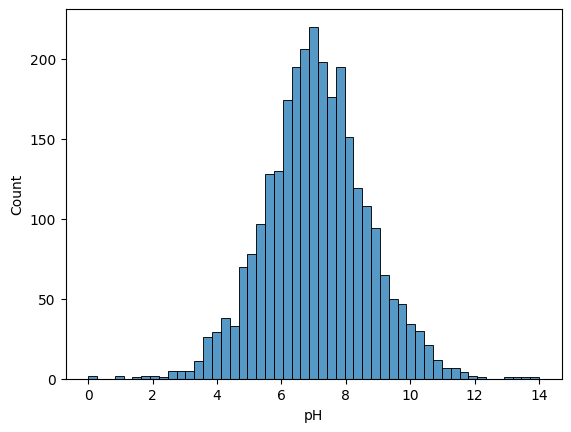

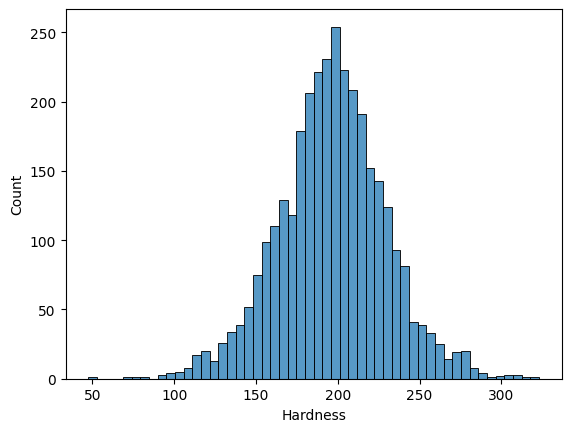

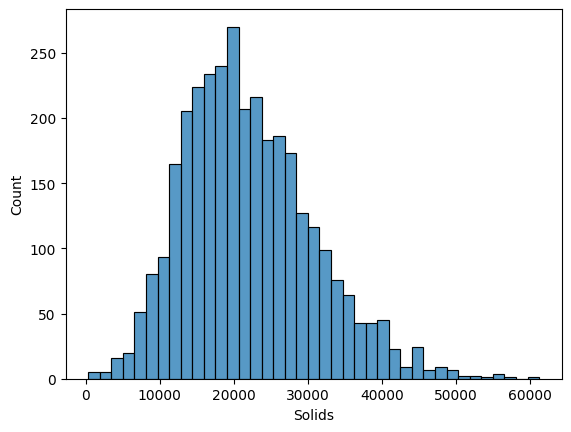

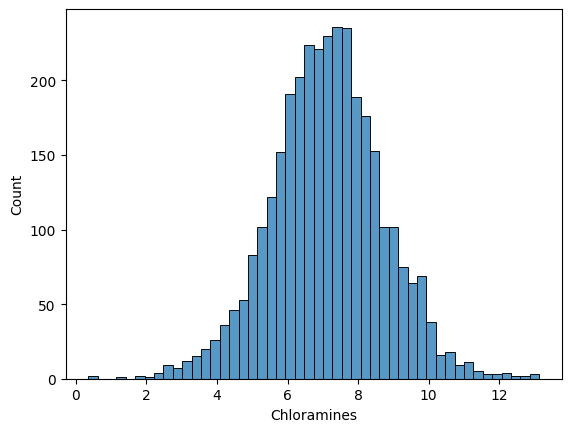

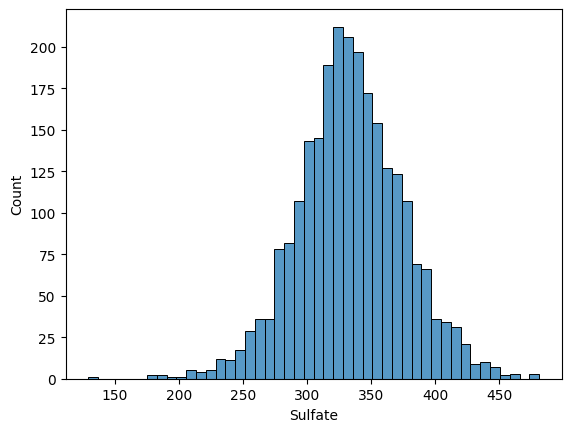

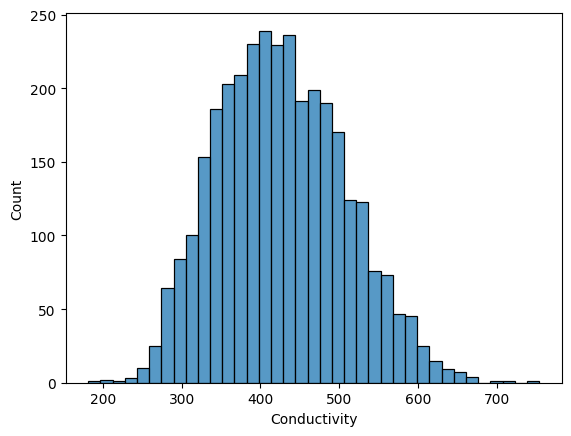

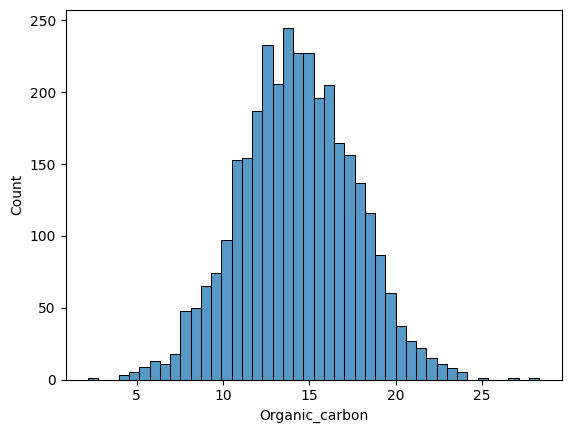

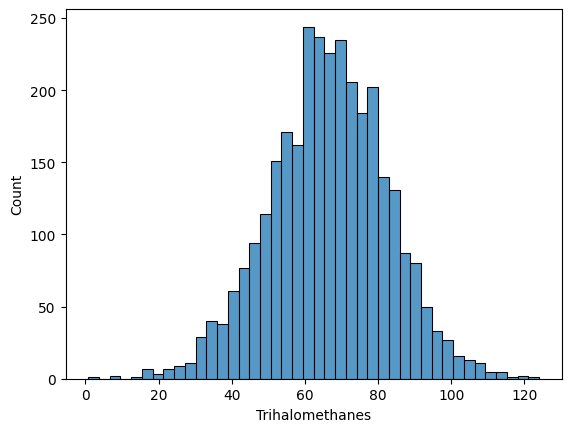

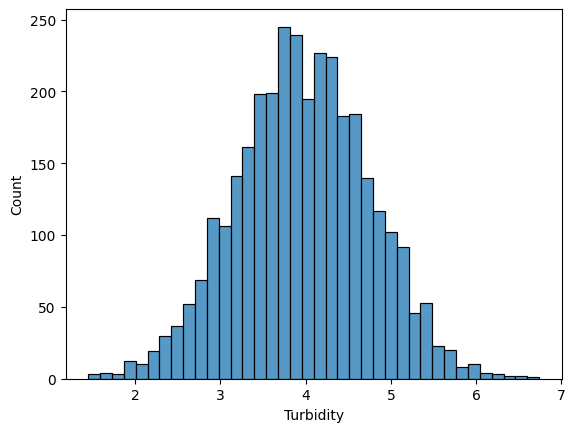

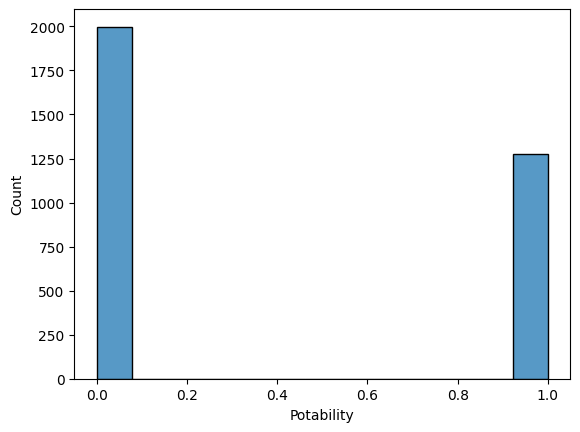

In [10]:
features_tovisualize = features.copy()
for col in features_tovisualize + [target_column]:
    plt.figure()
    sns.histplot(data=df, x=col)

<Axes: ylabel='count'>

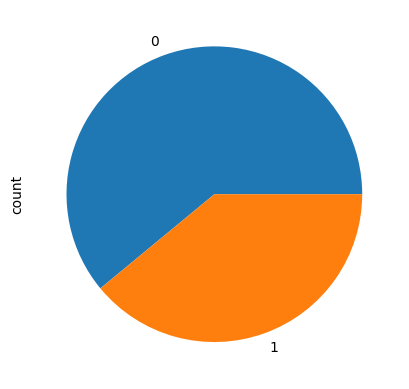

In [11]:
df.Potability.value_counts().plot(kind ='pie')


In [12]:
# Odnos klasa za Potability u procentima
potability_counts = df['Potability'].value_counts(dropna=False).sort_index()
potability_percent = (potability_counts / len(df) * 100).round(2)
display(pd.DataFrame({
    'count': potability_counts,
    'percent': potability_percent
}))

,count,percent
Potability,,
0,1998,60.99
1,1278,39.01


In [13]:
duplicate_rows = df[df.duplicated()]
print("Duplikati:")
print(duplicate_rows)

Duplikati:
Empty DataFrame
Columns: [pH, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, Potability]
Index: []


## Pregled tipa feature-a

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pH               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Iz ovog mozemo da zakljucimo da nam nije potrebno konvertovanje tipa feature-a iz kategorickih u numericke vrednosti, tako da taj postupak preskacemo. 

## Matrica korelacije - pregled medjusobne zavisnosti kolona

<Axes: >

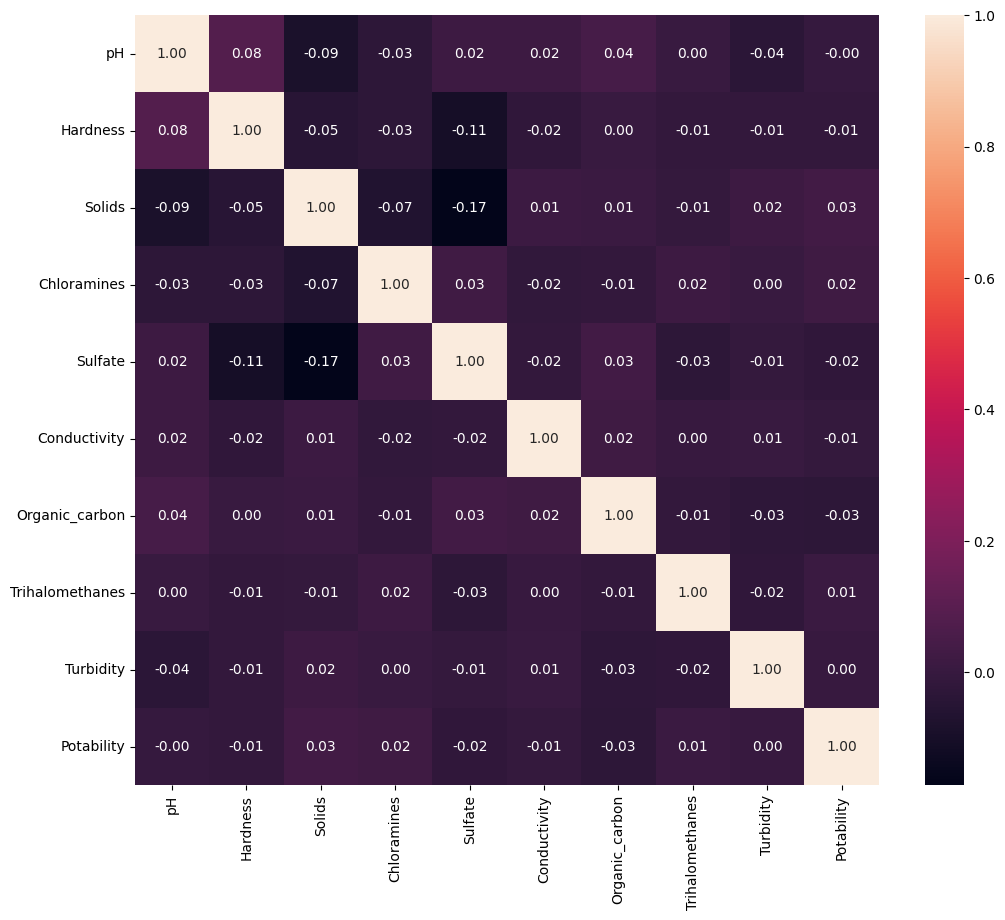

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Ovde mozemo da vidimo da nijedna kolona nema preveliku korelacioju s ostalim kolonama, osim kolone Solids za koju smo vec rekli da vidimo malo vece odstupanje u opsegu i prosecnom vrednoscu u zavisnosti od toga da li je voda pitka.

## Analiza nedostajucih vrednosti

In [16]:
df.describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


Ovde vidimo da su vrednosti razlicitog opsega za svaku kolonu, tako da ce najverovatnije biti neophodna normalizacija podataka u kasnijim koracima.

In [17]:
df.isnull().sum()

pH                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Mozemo da vidimo da postoje tri kolone koje imaju null vrednosti, i od toga 2/3 kolone deluju kao da su znacajne za ceo dataset sto mozemo da vidimo kasnije, tako da ce handlovanje nedostajucih vrednosti dosta da utice na preciznost celokupnog dataseta.

## Brisanje redova koji imaju sve tri prazne kolone 

In [18]:
rows_with_multiple_nulls = df[df.isnull().sum(axis=1) == 3]

print("Redovi sa tri null kolona:")
rows_with_multiple_nulls.describe()

Redovi sa tri null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,0.0,9.000000,9.000000,9.000000,0.0,9.000000,9.000000,0.0,9.000000,9.000000
mean,NaN,197.615548,22256.806396,6.832987,NaN,448.285723,13.164470,NaN,3.894027,0.111111
std,NaN,28.865246,11891.655823,1.436351,NaN,95.851968,3.088826,NaN,0.624907,0.333333
min,NaN,143.300200,11954.700730,4.933662,NaN,293.477998,8.816487,NaN,3.017985,0.000000
25%,NaN,184.993731,16162.262307,6.087949,NaN,391.238714,11.318807,NaN,3.451740,0.000000
50%,NaN,202.079864,17777.100086,6.657053,NaN,448.846036,12.934160,NaN,3.832479,0.000000
75%,NaN,221.620058,20944.620814,7.627524,NaN,538.621803,13.744749,NaN,4.439215,0.000000
max,NaN,229.771350,44982.734155,8.898024,NaN,566.339294,19.585497,NaN,4.863378,1.000000


Vidimo da imamo 9 redova koji imaju te tri kolone sa null vrednostima, tako da brisanje istih nece mnogo da utice na celokupan dataset.

In [19]:
rows_with_two_nulls = df[df.isnull().sum(axis=1) >= 2]
print("Redovi sa dve null kolona:")
rows_with_two_nulls.describe()

Redovi sa dve null kolona:


,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,31.000000,160.000000,160.000000,160.000000,17.000000,160.000000,160.000000,103.000000,160.000000,160.000000
mean,7.266158,194.426976,21681.200741,7.235609,344.869401,416.153398,14.259183,66.396986,3.945639,0.356250
std,1.641398,31.927739,8700.158728,1.530558,55.535833,73.601037,3.434545,16.845924,0.737124,0.480394
min,4.059431,103.464759,4142.499001,2.750837,234.285621,274.696540,5.426650,18.400012,1.659799,0.000000
25%,6.378001,175.209056,15269.219052,6.335273,317.837525,363.808279,11.772790,56.650264,3.456675,0.000000
50%,6.941719,194.769975,21040.453789,7.329852,340.348645,414.129696,14.088256,67.869964,3.880334,0.000000
75%,7.987152,216.297958,26670.066380,8.278829,369.862672,467.846179,16.622855,77.148871,4.400436,1.000000
max,10.851860,287.370208,47591.283183,11.251507,462.474215,599.614535,28.300000,118.357275,6.204846,1.000000


In [20]:
# Test different thresholds for removing rows with NaN values
print("=" * 70)
print("POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN")
print("=" * 70)

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, roc_auc_score

comparison_results = []

for threshold in [1, 2, 3]:
    # Get rows with >= threshold NaN values
    rows_to_drop = df[df.isnull().sum(axis=1) >= threshold]
    df_filtered = df.drop(rows_to_drop.index)
    
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    df_filtered_copy = df_filtered.copy()
    df_filtered_copy.iloc[:, :-1] = imputer.fit_transform(df_filtered_copy.iloc[:, :-1])
    
    print(f"\n--- Prag: >= {threshold} NaN vrednosti ---")
    print(f"Redovi izbrisani: {len(rows_to_drop)} ({100*len(rows_to_drop)/len(df):.1f}%)")
    print(f"Preostali redovi: {len(df_filtered)} ({100*len(df_filtered)/len(df):.1f}%)")
    
    X = df_filtered_copy.drop(columns=['Potability'])
    y = df_filtered_copy['Potability']
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    models = {
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    }
    
    # Define scoring metrics
    scoring_metrics = {
        'Accuracy': 'accuracy',
        'F1': make_scorer(f1_score, zero_division=0),
        'Precision': make_scorer(precision_score, zero_division=0),
        'Recall': make_scorer(recall_score, zero_division=0),
        'ROC-AUC': 'roc_auc'
    }
    
    for model_name, model in models.items():
        # Cross-validation sa svim metrikama
        cv_results = cross_validate(model, X, y, cv=kf, scoring=scoring_metrics, return_train_score=False)
        
        print(f"\n  {model_name}:")
        for metric_name in scoring_metrics.keys():
            scores = cv_results[f'test_{metric_name}']
            print(f"    {metric_name:12} | Mean: {scores.mean():.4f} (+/- {scores.std():.4f})")
            
            comparison_results.append({
                'Prag': threshold,
                'Model': model_name,
                'Metrika': metric_name,
                'Vrednost': scores.mean(),
                'Std': scores.std(),
                'Redova_izbrisano': len(rows_to_drop)
            })

print("\n" + "=" * 70)
comparison_df = pd.DataFrame(comparison_results)
print("\nSUMARNI PRIKAZ - METRIKE:")
print(comparison_df.to_string(index=False))

# Create pivot table for better visualization
print("\n" + "=" * 70)
print("\nPIVOT TABELA - ACCURACY:")
pivot_acc = comparison_df[comparison_df['Metrika'] == 'Accuracy'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_acc.round(4))

print("\n" + "=" * 70)
print("\nPIVOT TABELA - F1 SCORE:")
pivot_f1 = comparison_df[comparison_df['Metrika'] == 'F1'].pivot_table(
    index='Model', columns='Prag', values='Vrednost', aggfunc='first'
)
print(pivot_f1.round(4))

POREĐENJE RAZLIČITIH PRAGOVA ZA BRISANJE REDOVA SA NaN

--- Prag: >= 1 NaN vrednosti ---
Redovi izbrisani: 1265 (38.6%)
Preostali redovi: 2011 (61.4%)

  CatBoost:
    Accuracy     | Mean: 0.6947 (+/- 0.0098)
    F1           | Mean: 0.5317 (+/- 0.0165)
    Precision    | Mean: 0.6985 (+/- 0.0297)
    Recall       | Mean: 0.4303 (+/- 0.0231)
    ROC-AUC      | Mean: 0.7256 (+/- 0.0207)

  RandomForest:
    Accuracy     | Mean: 0.6793 (+/- 0.0142)
    F1           | Mean: 0.5016 (+/- 0.0333)
    Precision    | Mean: 0.6722 (+/- 0.0314)
    Recall       | Mean: 0.4019 (+/- 0.0401)
    ROC-AUC      | Mean: 0.6996 (+/- 0.0123)

--- Prag: >= 2 NaN vrednosti ---
Redovi izbrisani: 160 (4.9%)
Preostali redovi: 3116 (95.1%)

  CatBoost:
    Accuracy     | Mean: 0.6743 (+/- 0.0106)
    F1           | Mean: 0.4728 (+/- 0.0258)
    Precision    | Mean: 0.6454 (+/- 0.0195)
    Recall       | Mean: 0.3735 (+/- 0.0270)
    ROC-AUC      | Mean: 0.7015 (+/- 0.0094)

  RandomForest:
    Accuracy     | M

Kada se uporede verdnosti dobijene uklanjenjem redova sa vise od 3 NaN verdnosti, i sa vise od 2 NaN, i basemodel, mozemo da zaklju;imo da najbolji rezultart daje opcija sa uklanjnjem redova sa 3 NaN vrednosti 

In [21]:
# Detaljne tabele za svaku metriku
print("\n" + "=" * 70)
print("DETALJNE TABELE ZA SVE METRIKE")
print("=" * 70)

for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'ROC-AUC']:
    print(f"\n{'=' * 70}")
    print(f"  {metric.upper()}")
    print(f"{'=' * 80}")
    
    metric_data = comparison_df[comparison_df['Metrika'] == metric].copy()
    metric_data['Vrednost'] = metric_data['Vrednost'].round(4)
    metric_data['Std'] = metric_data['Std'].round(4)
    
    pivot_display = metric_data.pivot_table(
        index='Model',
        columns='Prag',
        values=['Vrednost', 'Std'],
        aggfunc='first'
    )
    
    # Flatten the multi-index columns for better readability
    for prag in [1, 2, 3]:
        print(f"\n  Prag: >= {prag} NaN vrednosti")
        for model in metric_data['Model'].unique():
            data = metric_data[(metric_data['Model'] == model) & (metric_data['Prag'] == prag)]
            if len(data) > 0:
                row = data.iloc[0]
                print(f"    {model:15} | {row['Vrednost']:.4f} ± {row['Std']:.4f}")


DETALJNE TABELE ZA SVE METRIKE

  ACCURACY

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.6947 ± 0.0098
    RandomForest    | 0.6793 ± 0.0142

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.6743 ± 0.0106
    RandomForest    | 0.6691 ± 0.0057

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.6774 ± 0.0127
    RandomForest    | 0.6676 ± 0.0180

  F1

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.5317 ± 0.0165
    RandomForest    | 0.5016 ± 0.0333

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.4728 ± 0.0258
    RandomForest    | 0.4557 ± 0.0248

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.4695 ± 0.0266
    RandomForest    | 0.4450 ± 0.0358

  PRECISION

  Prag: >= 1 NaN vrednosti
    CatBoost        | 0.6985 ± 0.0297
    RandomForest    | 0.6722 ± 0.0314

  Prag: >= 2 NaN vrednosti
    CatBoost        | 0.6454 ± 0.0195
    RandomForest    | 0.6415 ± 0.0158

  Prag: >= 3 NaN vrednosti
    CatBoost        | 0.6565 ± 0.0268
    RandomForest    | 0.6420 ± 0.0437



In [22]:
df_droped = df.drop(rows_with_multiple_nulls.index)

## Imputiranje praznih vrednosti 

### Metoda imputacije: Mean po grupama (Group Mean Imputation)

U nasem slucaju, hemijske karakteristike vode se razlikuju u zavisnosti od toga da li je voda pitka ili ne. Na primer, pitka voda ima drugaciji prosecni pH od nepitke. Zato grupno imputiranje (po Potability klasi) bolje cuva prirodnu strukturu podataka.
Ova metoda se kasnije pokazala kao najefektivnija za preciznost modela.

In [23]:
from sklearn.impute import KNNImputer

# Ucitaj sirove podatke (sa NaN vrednostima)
df_raw = pd.read_csv(abspath, header=0, names=columns)

# Grupna mean imputacija (po Potability)
df_group = df_raw.copy()
for col in ['pH', 'Sulfate', 'Trihalomethanes']:
    df_group[col] = df_group[col].fillna(df_group.groupby('Potability')[col].transform('mean'))

# KNN imputacija
df_knn = df_raw.copy()
imputer_knn = KNNImputer(n_neighbors=5)
df_knn[df_knn.columns[:-1]] = imputer_knn.fit_transform(df_knn[df_knn.columns[:-1]])

# Uporedna evaluacija
clear_preprocessing_results()
print("=== Grupna mean imputacija ===")
evaluate_models_after_step(df_group, "Imputacija: Group Mean", compare_scalers=False)

print("\n=== KNN imputacija ===")
evaluate_models_after_step(df_knn, "Imputacija: KNN", compare_scalers=False)

=== Grupna mean imputacija ===

EVALUACIJA: Imputacija: Group Mean
Dataset: 3276 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1998), 1: np.int64(1278)}
  DecisionTree       | Accuracy: 0.7314 (+/- 0.0078)
  RandomForest       | Accuracy: 0.7988 (+/- 0.0115)
  ExtraTrees         | Accuracy: 0.6993 (+/- 0.0104)
  XGBoost            | Accuracy: 0.7827 (+/- 0.0129)
  LightGBM           | Accuracy: 0.7869 (+/- 0.0222)
  CatBoost           | Accuracy: 0.8083 (+/- 0.0184)
  KNN                | Accuracy: 0.6377 (+/- 0.0122)
  SVM                | Accuracy: 0.6731 (+/- 0.0166)

  NAJBOLJI: CatBoost (0.8083)

=== KNN imputacija ===

EVALUACIJA: Imputacija: KNN
Dataset: 3276 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1998), 1: np.int64(1278)}
  DecisionTree       | Accuracy: 0.5940 (+/- 0.0142)
  RandomForest       | Accuracy: 0.6709 (+/- 0.0136)
  ExtraTrees         | Accuracy: 0.6819 (+/- 0.0044)
  XGBoost            | Accuracy: 0.6377 (+/- 0.0173)
  LightGBM           | Accura

,Step,Model,Accuracy_Mean,Accuracy_Std
0,Imputacija: KNN,DecisionTree,0.594011,0.014193
1,Imputacija: KNN,RandomForest,0.670939,0.013604
2,Imputacija: KNN,ExtraTrees,0.681928,0.004433
3,Imputacija: KNN,XGBoost,0.637669,0.017292
4,Imputacija: KNN,LightGBM,0.663923,0.014334
5,Imputacija: KNN,CatBoost,0.677655,0.019611
6,Imputacija: KNN,KNN,0.627287,0.012403
7,Imputacija: KNN,SVM,0.675212,0.009228


In [24]:
df['pH']=df['pH'].fillna(df.groupby(['Potability'])['pH'].transform('mean'))
df['Sulfate']=df['Sulfate'].fillna(df.groupby(['Potability'])['Sulfate'].transform('mean'))
df['Trihalomethanes']=df['Trihalomethanes'].fillna(df.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

In [25]:
df_droped = df.drop(rows_with_multiple_nulls.index)

df_droped['pH']=df_droped['pH'].fillna(df_droped.groupby(['Potability'])['pH'].transform('mean'))
df_droped['Sulfate']=df_droped['Sulfate'].fillna(df_droped.groupby(['Potability'])['Sulfate'].transform('mean'))
df_droped['Trihalomethanes']=df_droped['Trihalomethanes'].fillna(df_droped.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

clear_preprocessing_results()
evaluate_models_after_step(df_droped, "2. Nakon imputacije", compare_scalers=False)


EVALUACIJA: 2. Nakon imputacije
Dataset: 3267 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1277)}
  DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
  RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
  ExtraTrees         | Accuracy: 0.7123 (+/- 0.0155)
  XGBoost            | Accuracy: 0.7891 (+/- 0.0158)
  LightGBM           | Accuracy: 0.7879 (+/- 0.0167)
  CatBoost           | Accuracy: 0.8118 (+/- 0.0146)
  KNN                | Accuracy: 0.6253 (+/- 0.0177)
  SVM                | Accuracy: 0.6774 (+/- 0.0155)

  NAJBOLJI: CatBoost (0.8118)


,Step,Model,Accuracy_Mean,Accuracy_Std
0,2. Nakon imputacije,DecisionTree,0.725122,0.021669
1,2. Nakon imputacije,RandomForest,0.794305,0.018610
2,2. Nakon imputacije,ExtraTrees,0.712274,0.015473
3,2. Nakon imputacije,XGBoost,0.789097,0.015808
4,2. Nakon imputacije,LightGBM,0.787874,0.016712
5,2. Nakon imputacije,CatBoost,0.811751,0.014619
6,2. Nakon imputacije,KNN,0.625343,0.017676
7,2. Nakon imputacije,SVM,0.677382,0.015534


In [26]:
df = df.drop(rows_with_multiple_nulls.index)

In [27]:
clear_preprocessing_results()
evaluate_models_after_step(df, "2. Nakon imputacije", compare_scalers=False)


EVALUACIJA: 2. Nakon imputacije
Dataset: 3267 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1990), 1: np.int64(1277)}
  DecisionTree       | Accuracy: 0.7251 (+/- 0.0217)
  RandomForest       | Accuracy: 0.7943 (+/- 0.0186)
  ExtraTrees         | Accuracy: 0.7123 (+/- 0.0155)
  XGBoost            | Accuracy: 0.7891 (+/- 0.0158)
  LightGBM           | Accuracy: 0.7879 (+/- 0.0167)
  CatBoost           | Accuracy: 0.8118 (+/- 0.0146)
  KNN                | Accuracy: 0.6253 (+/- 0.0177)
  SVM                | Accuracy: 0.6774 (+/- 0.0155)

  NAJBOLJI: CatBoost (0.8118)


,Step,Model,Accuracy_Mean,Accuracy_Std
0,2. Nakon imputacije,DecisionTree,0.725122,0.021669
1,2. Nakon imputacije,RandomForest,0.794305,0.018610
2,2. Nakon imputacije,ExtraTrees,0.712274,0.015473
3,2. Nakon imputacije,XGBoost,0.789097,0.015808
4,2. Nakon imputacije,LightGBM,0.787874,0.016712
5,2. Nakon imputacije,CatBoost,0.811751,0.014619
6,2. Nakon imputacije,KNN,0.625343,0.017676
7,2. Nakon imputacije,SVM,0.677382,0.015534


In [28]:
df.isnull().sum()

pH                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

Kao sto vidimo, vrednosti su uspesno popunjene i vise nemamo praznih kolona. Sada mozemo da vidimo kako izgledaju podaci u zavisnosti od ciljne kolone - Potability.

In [29]:
df[df['Potability']==0].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.000000,1990.0
mean,7.085378,196.702451,21772.552012,7.092913,334.564290,426.671628,14.372386,66.303555,3.965866,0.0
std,1.548594,31.089068,8527.779592,1.501323,32.006042,79.982881,3.336573,15.674049,0.780915,0.0
min,0.000000,98.452931,320.942611,1.683993,203.444521,181.483754,4.371899,0.738000,1.450000,0.0
25%,6.217350,177.756096,15663.057382,6.156857,319.266920,368.498530,12.118536,56.404562,3.444062,0.0
50%,7.085378,197.090572,20827.950711,7.090334,334.564290,422.229331,14.310837,66.303555,3.949117,0.0
75%,7.945026,216.106273,27006.249009,8.066462,348.396008,480.580767,16.660188,76.599159,4.496106,0.0
max,14.000000,304.235912,61227.196008,12.653362,460.107069,753.342620,28.300000,120.030077,6.739000,0.0


In [30]:
df[df['Potability']==1].describe()

,pH,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.000000,1277.0
mean,7.073783,195.841857,22388.784145,7.170074,332.566990,425.322500,14.156645,66.539684,3.968733,1.0
std,1.344479,35.530558,9102.961906,1.703452,41.881787,82.051309,3.261649,15.978198,0.781014,0.0
min,0.227499,47.432000,728.750830,0.352000,129.000000,201.619737,2.200000,8.175876,1.492207,1.0
25%,6.351287,174.480427,15668.273618,6.093750,312.982727,360.932804,12.032377,56.910254,3.430167,1.0
50%,7.073783,196.649823,21208.618285,7.217409,332.566990,420.594592,14.162010,66.539684,3.958609,1.0
75%,7.780869,218.062384,27977.673208,8.199318,354.821194,484.104784,16.352858,77.079780,4.510578,1.0
max,13.175402,323.124000,56488.672413,13.127000,481.030642,695.369528,23.604298,124.000000,6.494249,1.0


In [31]:
df.groupby('Potability').mean().T

Potability,0,1
pH,7.085378,7.073783
Hardness,196.702451,195.841857
Solids,21772.552012,22388.784145
Chloramines,7.092913,7.170074
Sulfate,334.564290,332.566990
Conductivity,426.671628,425.322500
Organic_carbon,14.372386,14.156645
Trihalomethanes,66.303555,66.539684
Turbidity,3.965866,3.968733


Iz ovih podataka mozemo da uocimo da dataset nije balansiran, postoje vise slogova gde je voda oznacena kao nepitka, a i sam raspon vrednosti se razlikuje, pogotovo za kolonu Solids i Hardness. Sada mozemo da kreiramo i matricu korelacije da vidimo koja je medjusobna zavinost svih tih kolona:

<Axes: >

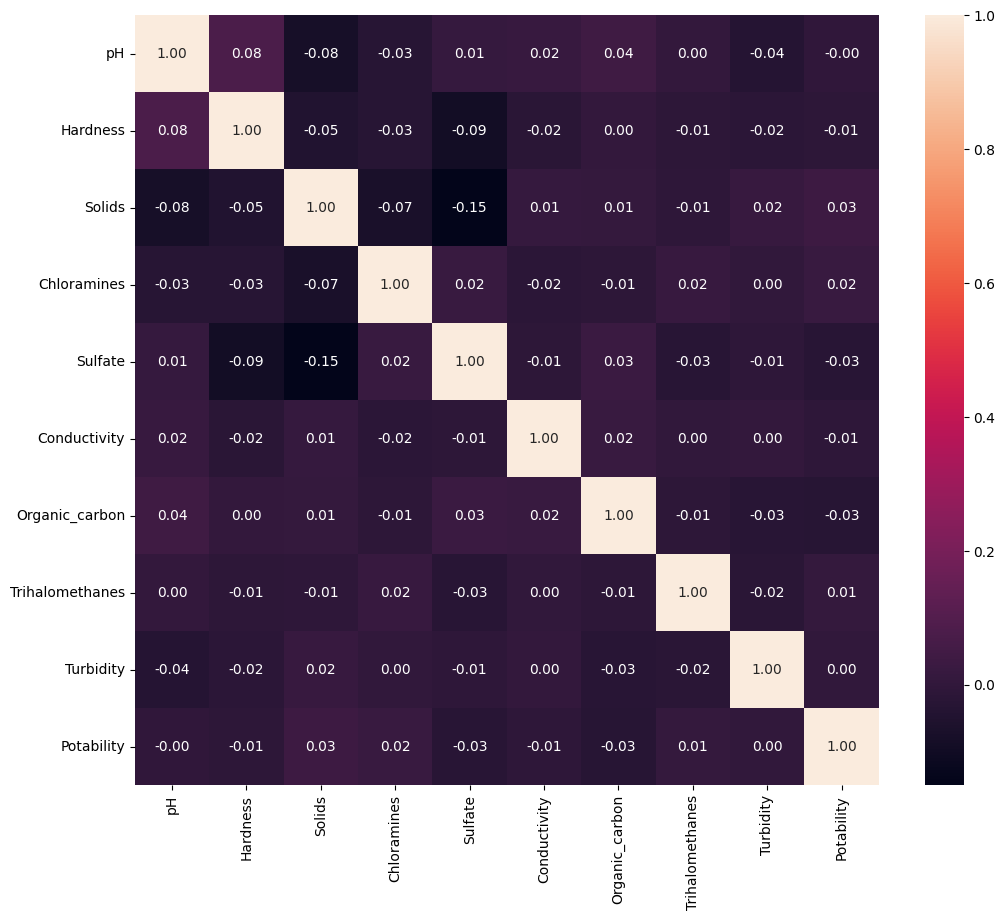

In [32]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

Nakon izvrsenog imputiranja praznih vrednosti, vidimo da se korelacija u krajnjem slucaju jos vise smanjila, sto je mozda i ocekivano.

Izvucicemo sve feature-e da bismo lakse izvukli šumove po svakoj koloni:

In [33]:
numerical_features = df.columns.tolist()

### Metode detekcije outliera

| Metoda | Formula | Prag | Osetljivost | Tipican procenat outliera (normalna distribucija) |
|--------|---------|------|-------------|----------------------------------------------------|
| **Z-score** | (x - mean) / std | |z| > 3 | Niska (3 std od proseka) | ~0.27% |
| **IQR** | Q1 - 1.5*IQR, Q3 + 1.5*IQR | Van opsega | Visoka | ~4.3% |
| **Mod Z-score** | 0.6745(xi – x̃) / MAD | -3.5 > x > 3.5 | Srednja | ~0.05% |

- Vazno jer imamo relativno mali dataset (~3000 uzoraka) i ne mozemo sebi dozvoliti da izgubimo previse podataka
- RandomForest i ostali tree-based modeli su otporni na outliere, ali brisanje outliera i dalje moze da promeni ishod tacnosti modela

In [34]:
def outliers_iqr(x: pd.Series):
    q1, q3 = np.percentile(x, [25, 75])
    iqr = q3 - q1
    
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    return np.where((x > upper_bound) | (x < lower_bound))[0]

def outliers_z_score(ys: pd.Series):
    threshold = 3

    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

def outliers_modified_z_score(ys: pd.Series):
    threshold = 3.5

    median_y = np.median(ys)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    
    if median_absolute_deviation_y == 0:
        median_absolute_deviation_y = np.finfo(np.double).min
    
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y
                         for y in ys]
    return np.where(np.abs(modified_z_scores) > threshold)[0]


outliers = {}
print("Outliers:",' ' * 26,"IQR ZScore ModZScore")
for col in numerical_features:
    outliersIQR = outliers_iqr(df[col])
    outliersZScore = outliers_z_score(df[col])
    outliersModZScore = outliers_modified_z_score(df[col])
    outliers[col] = (outliersIQR, outliersZScore, outliersModZScore)
    print(f"Column '{col:24}': {len(outliersIQR):5} {len(outliersZScore):6} {len(outliersModZScore):9}")
print()



Outliers:                            IQR ZScore ModZScore
Column 'pH                      ':   142     27        36
Column 'Hardness                ':    83     18        13
Column 'Solids                  ':    46     20        10
Column 'Chloramines             ':    61     20        13
Column 'Sulfate                 ':   261     34       110
Column 'Conductivity            ':    11      7         1
Column 'Organic_carbon          ':    25      4         3
Column 'Trihalomethanes         ':    53     18         5
Column 'Turbidity               ':    19      8         1
Column 'Potability              ':     0      0         0



Od tri metode koje smo iskoristili, Z-score je "najmanje osetljiv" na sumove sto nam odgovara, jer ne smemo da brisemo previse redova zbog manjka podataka s kojim raspolazemo.

In [35]:
z_scores = np.abs((df - df.mean()) / df.std())

# threshold for Z-scores
threshold = 3
outliers = (z_scores > threshold).any(axis=1)
# remove outliers
df_no_outliers = df[~outliers]



EVALUACIJA: 2. Bez outliera
Dataset: 3121 uzoraka, 9 osobina
Distribucija klasa: {0: np.int64(1923), 1: np.int64(1198)}

  --- NoScaler ---
    DecisionTree       | Accuracy: 0.7200 (+/- 0.0190)
    RandomForest       | Accuracy: 0.7985 (+/- 0.0125)
    ExtraTrees         | Accuracy: 0.6982 (+/- 0.0132)
    XGBoost            | Accuracy: 0.7895 (+/- 0.0203)
    LightGBM           | Accuracy: 0.7866 (+/- 0.0129)
    CatBoost           | Accuracy: 0.8039 (+/- 0.0186)
    KNN                | Accuracy: 0.5482 (+/- 0.0137)
    SVM                | Accuracy: 0.6161 (+/- 0.0007)

  --- Standard ---
    DecisionTree       | Accuracy: 0.7200 (+/- 0.0190)
    RandomForest       | Accuracy: 0.7985 (+/- 0.0125)
    ExtraTrees         | Accuracy: 0.6982 (+/- 0.0132)
    XGBoost            | Accuracy: 0.7892 (+/- 0.0200)
    LightGBM           | Accuracy: 0.7873 (+/- 0.0200)
    CatBoost           | Accuracy: 0.8036 (+/- 0.0191)
    KNN                | Accuracy: 0.6197 (+/- 0.0113)
    SVM       

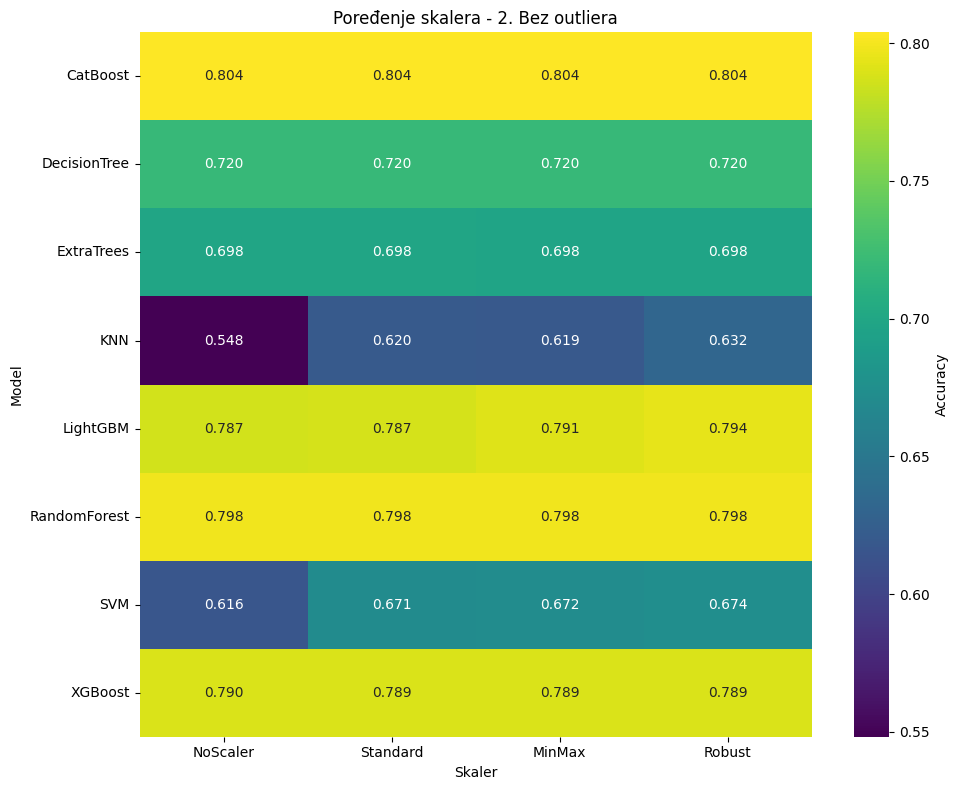

In [36]:
# Evaluate models after outlier removal
results_df = evaluate_models_after_step(df_no_outliers, "2. Bez outliera", compare_scalers=True)

### Zakljucak nakon brisanja outliera
Kao sto vidimo, tacnost modela nam se pogorsala nakon sto smo obrisali outliere, sto je i ocekivano, jer najmanja promena u broju podataka moze da napravi jak efekat na tacnost modela zbog malog broja podataka. Stoga, zadrzacemo sve outliere kako bismo odrzali sto vecu tacnost.

## Balansiranje klasa (Resampling)

Nebalansirane klase su cest problem u klasifikaciji. U nasem datasetu imamo vise nepitke vode (~60%) nego pitke (~40%). Ovo moze navesti model da "favorizuje" vecinu klasu.

**Vazno:** Balansiranje se mora raditi **samo na train setu** da bi se izbeglo curenje podataka (data leakage). Ako radimo upsampling na celom datasetu pre split-a, isti (duplirani) podaci mogu zavrsiti i u train i u test setu, sto daje lazno optimisticne rezultate.

Poredimo dve tehnike:
- **Upsampling**: Dupliramo uzorke manjinske klase da bismo dobili vise podataka za trening
- **Downsampling**: Smanjujemo uzorke vecinske klase da bismo imali balansirane klase

In [37]:
# Balansiranje klasa - poređenje svih metoda sa SVIM METRIKAMA
%pip install imblearn

from sklearn.utils import resample, shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np

def balance_train_data(X_train, y_train, method='upsample', random_state=42):
    """
    Balansira train podatke koristeci upsampling, downsampling ili SMOTE.
    """
    if method == 'none':
        return X_train, y_train

    if method == 'smote':
        smote = SMOTE(random_state=random_state)
        X_balanced, y_balanced = smote.fit_resample(X_train, y_train)
        return X_balanced, y_balanced

    train_data = pd.DataFrame(X_train.copy())
    train_data['target'] = y_train

    class_0 = train_data[train_data['target'] == 0]
    class_1 = train_data[train_data['target'] == 1]

    if method == 'upsample':
        n_samples = max(len(class_0), len(class_1))
        if len(class_0) < len(class_1):
            class_0 = resample(class_0, replace=True, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=True, n_samples=n_samples, random_state=random_state)
    else:  # downsample
        n_samples = min(len(class_0), len(class_1))
        if len(class_0) > len(class_1):
            class_0 = resample(class_0, replace=False, n_samples=n_samples, random_state=random_state)
        else:
            class_1 = resample(class_1, replace=False, n_samples=n_samples, random_state=random_state)

    balanced_data = pd.concat([class_0, class_1])
    balanced_data = shuffle(balanced_data, random_state=random_state)

    X_balanced = balanced_data.drop('target', axis=1).values
    y_balanced = balanced_data['target'].values

    return X_balanced, y_balanced

def evaluate_all_metrics(df_data, method='none', target_col='Potability', k=5):

    X = df_data.drop(columns=[target_col]).values
    y = df_data[target_col].values

    models = {
        'DecisionTree': DecisionTreeClassifier(random_state=42),
        'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
        'XGBoost': XGBClassifier(random_state=42, verbosity=0, n_jobs=-1),
        'LightGBM': LGBMClassifier(random_state=42, verbose=-1, n_jobs=-1),
        'CatBoost': CatBoostClassifier(random_state=42, verbose=0),
    }

    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    results = {name: {'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
               for name in models.keys()}

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        X_train_balanced, y_train_balanced = balance_train_data(X_train, y_train, method=method, random_state=42+fold)

        for name, model in models.items():
            from sklearn.base import clone
            model_clone = clone(model)
            model_clone.fit(X_train_balanced, y_train_balanced)

            y_pred = model_clone.predict(X_test)
            y_proba = model_clone.predict_proba(X_test)[:, 1]

            results[name]['accuracy'].append(accuracy_score(y_test, y_pred))
            results[name]['f1'].append(f1_score(y_test, y_pred))
            results[name]['precision'].append(precision_score(y_test, y_pred))
            results[name]['recall'].append(recall_score(y_test, y_pred))
            results[name]['auc'].append(roc_auc_score(y_test, y_proba))

    summary = []
    for name, metrics in results.items():
        summary.append({
            'Model': name,
            'Accuracy': np.mean(metrics['accuracy']),
            'F1': np.mean(metrics['f1']),
            'Precision': np.mean(metrics['precision']),
            'Recall': np.mean(metrics['recall']),
            'AUC': np.mean(metrics['auc'])
        })

    return pd.DataFrame(summary)

# Distribucija klasa
print("Distribucija klasa:")
print(df['Potability'].value_counts())
print(f"Odnos: {df['Potability'].value_counts()[0]/len(df)*100:.1f}% / {df['Potability'].value_counts()[1]/len(df)*100:.1f}%")

# Evaluacija svih metoda
methods = {
    'BEZ BALANSIRANJA': 'none',
    'UPSAMPLING': 'upsample',
    'DOWNSAMPLING': 'downsample',
    'SMOTE': 'smote'
}

all_results = {}
for name, method in methods.items():
    print(f"\nEvaluacija: {name}...")
    all_results[name] = evaluate_all_metrics(df, method=method, k=5)

# Prikaz rezultata za svaku metodu
for name, results_df in all_results.items():
    print()
    print("=" * 85)
    print(f"{name}")
    print("=" * 85)
    print(results_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# UPOREDNA TABELA - prosek svih modela po metodi
print()
print("=" * 85)
print("PROSECNE METRIKE PO METODI BALANSIRANJA (prosek svih modela)")
print("=" * 85)

comparison_data = []
for name, results_df in all_results.items():
    comparison_data.append({
        'Metoda': name,
        'Accuracy': results_df['Accuracy'].mean(),
        'F1': results_df['F1'].mean(),
        'Precision': results_df['Precision'].mean(),
        'Recall': results_df['Recall'].mean(),
        'AUC': results_df['AUC'].mean()
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

# Najbolja metoda po svakoj metrici
print()
print("=" * 85)
print("NAJBOLJA METODA PO SVAKOJ METRICI")
print("=" * 85)
for metric in ['Accuracy', 'F1', 'Precision', 'Recall', 'AUC']:
    best_idx = comparison_df[metric].idxmax()
    best_method = comparison_df.loc[best_idx, 'Metoda']
    best_value = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12} -> {best_method:20} ({best_value:.4f})")


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.
Distribucija klasa:
Potability
0    1990
1    1277
Name: count, dtype: int64
Odnos: 60.9% / 39.1%

Evaluacija: BEZ BALANSIRANJA...

Evaluacija: UPSAMPLING...

Evaluacija: DOWNSAMPLING...

Evaluacija: SMOTE...

BEZ BALANSIRANJA
       Model  Accuracy     F1  Precision  Recall    AUC
DecisionTree    0.7251 0.6466     0.6503  0.6436 0.7105
RandomForest    0.7943 0.7038     0.8034  0.6272 0.8703
     XGBoost    0.7891 0.7121     0.7624  0.6687 0.8701
    LightGBM    0.7879 0.7029     0.7754  0.6437 0.8713
    CatBoost    0.8118 0.7283     0.8335  0.6476 0.8881

UPSAMPLING
       Model  Accuracy     F1  Precision  Recall    AUC
DecisionTree    0.7291 0.6398     0.6657  0.6178 0.7092
RandomForest    0.7900 0.6989     0.7933  0.6257 0.8649
     XGBoost    0.7919 0.7127     0.7740  0.6609 0.8687
    LightGBM    0.7916 0.7137     0.7702  0.6664 0.8749
    CatBoost    0.8020 0.7281     0.7852  0.6805 0.8857

DOWNSAMPLING
       Mo

In [38]:
import time

results, summary_df = hyperparameter_optimization(
    df, 
    target_col='Potability',
    models_to_tune=['CatBoost', 'RandomForest'],
    scaler='standard',
    cv=5,
    scoring='accuracy', 
    use_randomized=True,  
    n_iter=50
)


Skaler: standard, CV: 5, Scoring: accuracy
Metod: RandomizedSearchCV

Optimizacija: RandomForest...
  Najbolji score: 0.7759
  Najbolji parametri: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 10}

Optimizacija: CatBoost...
  Najbolji score: 0.7836
  Najbolji parametri: {'random_strength': 1, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'iterations': 1000, 'depth': 6, 'bagging_temperature': 0}

SUMARNI PREGLED - RANGIRANO PO SCORE-u:
  CatBoost        | Score: 0.7836
  RandomForest    | Score: 0.7759


In [39]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# Definicija metrika za cross_validate
scoring_metrics = {
    'accuracy': make_scorer(accuracy_score),
    'precision_0': make_scorer(precision_score, pos_label=0),
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_0': make_scorer(recall_score, pos_label=0),
    'recall_1': make_scorer(recall_score, pos_label=1),
    'f1_0': make_scorer(f1_score, pos_label=0),
    'f1_1': make_scorer(f1_score, pos_label=1)
}

def test_model(model, X: pd.DataFrame, Y: pd.DataFrame):
    #Prepare testing objects
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    #Training and testing
    cv_results = cross_validate(model, X, Y, scoring=scoring_metrics,
     cv=cv, n_jobs=-1)

    AccuScores = cv_results['test_accuracy']
    Prec0Scores = cv_results['test_precision_0']
    Prec1Scores = cv_results['test_precision_1']
    Rec0Scores = cv_results['test_recall_0']
    Rec1Scores = cv_results['test_recall_1']
    F10Scores = cv_results['test_f1_0']
    F11Scores = cv_results['test_f1_1']

    return { 
        'Accuracy': np.mean(AccuScores),
        'Precision 0': np.mean(Prec0Scores),
        'Precision 1': np.mean(Prec1Scores),
        'Recall 0': np.mean(Rec0Scores),
        'Recall 1': np.mean(Rec1Scores),
        'F1 0': np.mean(F10Scores),
        'F1 1': np.mean(F11Scores)
    }

## Evaluacija najboljeg modela
Matrica konfuzije, Feature Importance, ROC kriva i AUC score.

CROSS-VALIDATION REZULTATI (5-fold):
Accuracy po foldovima: [0.73853211 0.79357798 0.79479326 0.75344564 0.81163859]
Prosecna accuracy: 0.7784 (+/- 0.0276)

CLASSIFICATION REPORT (cross-validated):
              precision    recall  f1-score   support

 Nepitka (0)       0.78      0.89      0.83      1990
   Pitka (1)       0.78      0.60      0.68      1277

    accuracy                           0.78      3267
   macro avg       0.78      0.75      0.76      3267
weighted avg       0.78      0.78      0.77      3267



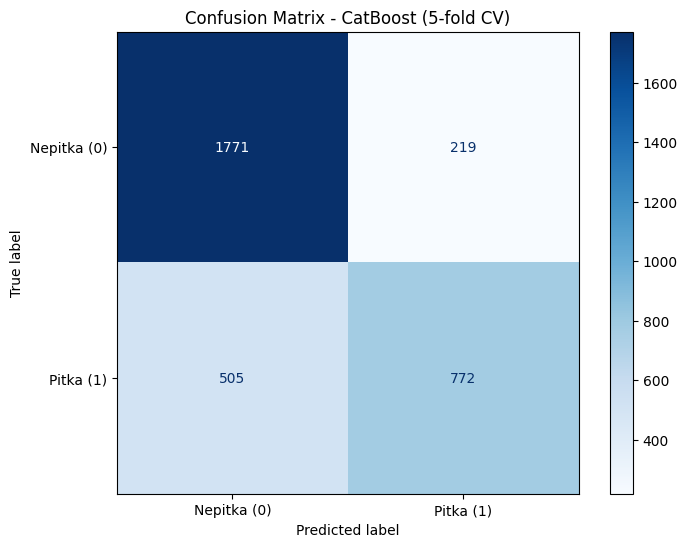

True Negatives (TN): 1771
False Positives (FP): 219
False Negatives (FN): 505
True Positives (TP): 772

Accuracy: 0.7784
Precision (Pitka): 0.7790
Recall (Pitka): 0.6045
F1 Score (Pitka): 0.6808


In [40]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df.drop('Potability', axis=1)
y = df['Potability']

# CatBoost model
model = CatBoostClassifier(random_state=42, verbose=0, iterations=500)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - CatBoost (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

CROSS-VALIDATION REZULTATI (5-fold):
Accuracy po foldovima: [0.74464832 0.79663609 0.77794793 0.75038285 0.80551302]
Prosecna accuracy: 0.7750 (+/- 0.0242)

CLASSIFICATION REPORT (cross-validated):
              precision    recall  f1-score   support

 Nepitka (0)       0.77      0.90      0.83      1990
   Pitka (1)       0.79      0.58      0.67      1277

    accuracy                           0.78      3267
   macro avg       0.78      0.74      0.75      3267
weighted avg       0.78      0.78      0.77      3267



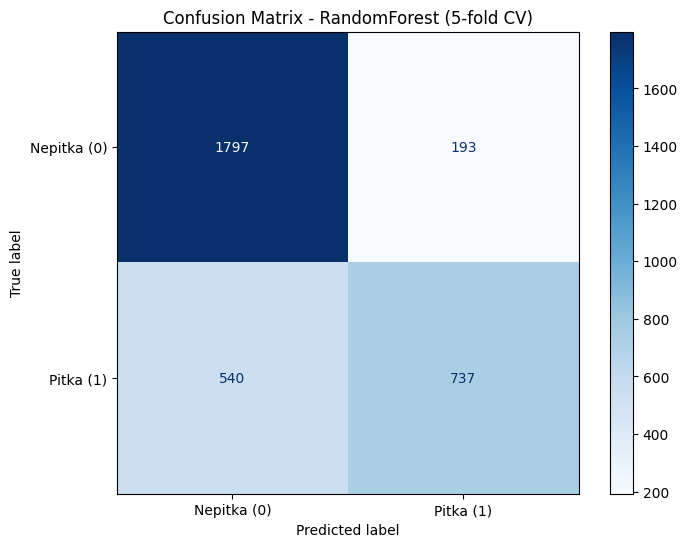

True Negatives (TN): 1797
False Positives (FP): 193
False Negatives (FN): 540
True Positives (TP): 737

Accuracy: 0.7756
Precision (Pitka): 0.7925
Recall (Pitka): 0.5771
F1 Score (Pitka): 0.6679


In [41]:
# =============================================================================
# EVALUACIJA NAJBOLJEG MODELA - Cross-Validation sa matricom konfuzije
# =============================================================================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import cross_val_predict, cross_val_score

# Priprema podataka
X = df.drop('Potability', axis=1)
y = df['Potability']

# RandomForest model
model = RandomForestClassifier(n_estimators=100, min_samples_split=5, min_samples_leaf=4, max_features='log2', max_depth=10)

# Cross-validation predikcije (svaki uzorak se predvidja kad je u test foldu)
y_pred_cv = cross_val_predict(model, X, y, cv=5)
y_pred_proba_cv = cross_val_predict(model, X, y, cv=5, method='predict_proba')[:, 1]

# Cross-validation scores
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("CROSS-VALIDATION REZULTATI (5-fold):")
print("="*60)
print(f"Accuracy po foldovima: {cv_scores}")
print(f"Prosecna accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# Classification report
print("\nCLASSIFICATION REPORT (cross-validated):")
print("="*60)
print(classification_report(y, y_pred_cv, target_names=['Nepitka (0)', 'Pitka (1)']))

# Confusion Matrix (agregirana iz svih foldova)
cm = confusion_matrix(y, y_pred_cv)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Nepitka (0)', 'Pitka (1)'])
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix - RandomForest (5-fold CV)')
plt.show()

# Prikaz vrednosti
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")
print(f"\nAccuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision (Pitka): {tp / (tp + fp):.4f}")
print(f"Recall (Pitka): {tp / (tp + fn):.4f}")
print(f"F1 Score (Pitka): {2*tp / (2*tp + fp + fn):.4f}")

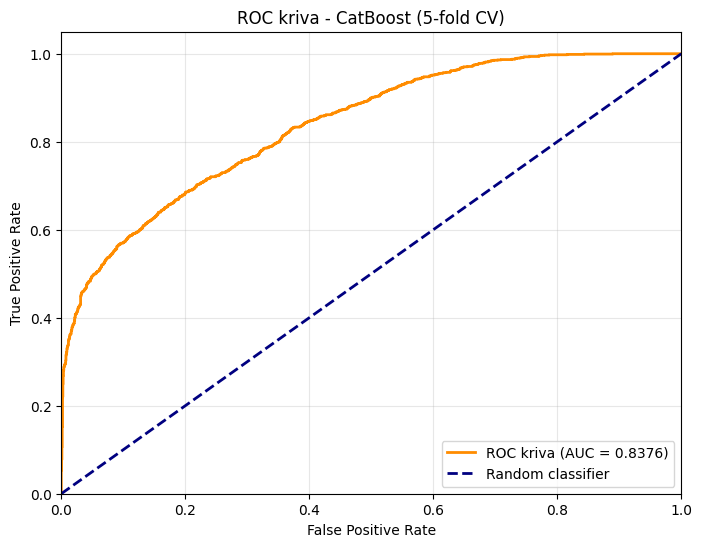

AUC Score: 0.8376


In [42]:
# ROC kriva i AUC (cross-validated)
fpr, tpr, thresholds = roc_curve(y, y_pred_proba_cv)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC kriva (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC kriva - CatBoost (5-fold CV)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

### Sumarna tabela: Baseline vs Finalni model

Learning rate set to 0.015526
0:	learn: 0.6869411	total: 2.4ms	remaining: 2.39s
1:	learn: 0.6795826	total: 4.88ms	remaining: 2.43s
2:	learn: 0.6741614	total: 7.2ms	remaining: 2.39s
3:	learn: 0.6674099	total: 9.41ms	remaining: 2.34s
4:	learn: 0.6626381	total: 11.4ms	remaining: 2.28s
5:	learn: 0.6546146	total: 13.3ms	remaining: 2.21s
6:	learn: 0.6484121	total: 15.3ms	remaining: 2.17s
7:	learn: 0.6442804	total: 17.2ms	remaining: 2.13s
8:	learn: 0.6405173	total: 19ms	remaining: 2.1s
9:	learn: 0.6358924	total: 20.9ms	remaining: 2.07s
10:	learn: 0.6316247	total: 22.9ms	remaining: 2.06s
11:	learn: 0.6263109	total: 25ms	remaining: 2.06s
12:	learn: 0.6215257	total: 27ms	remaining: 2.05s
13:	learn: 0.6177429	total: 28.8ms	remaining: 2.03s
14:	learn: 0.6112091	total: 30.8ms	remaining: 2.02s
15:	learn: 0.6072479	total: 32.7ms	remaining: 2.01s
16:	learn: 0.6021132	total: 34.7ms	remaining: 2.01s
17:	learn: 0.5975539	total: 36.8ms	remaining: 2s
18:	learn: 0.5949898	total: 39.1ms	remaining: 2.02s
19:	

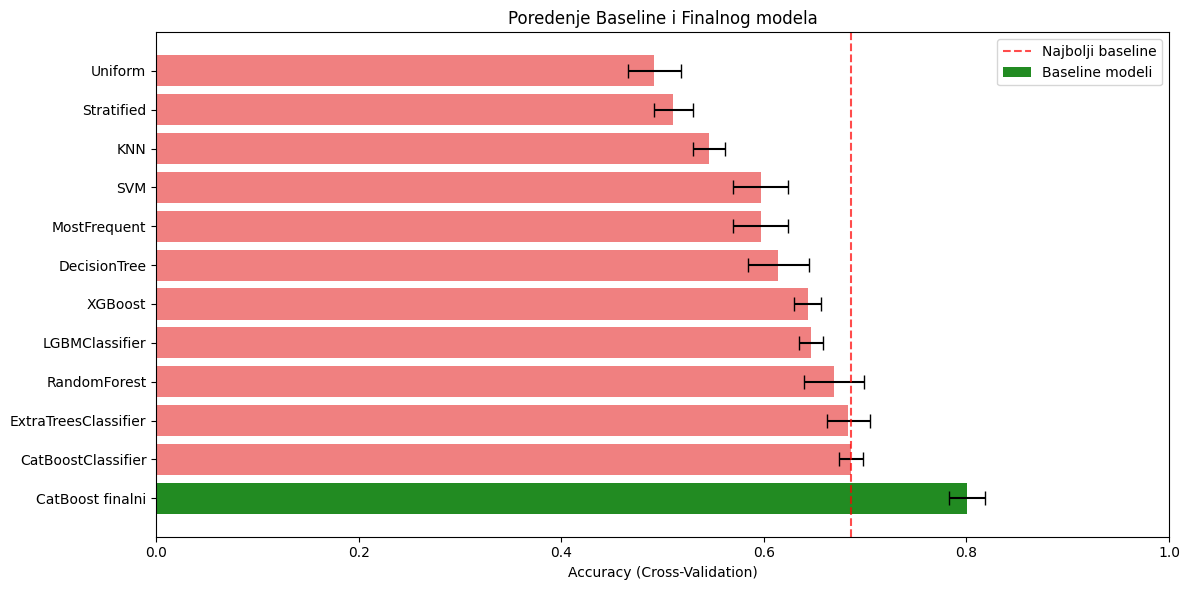


Poboljsanje u odnosu na najbolji baseline: 16.69%
Baseline (best): 0.6862 -> Finalni: 0.8007


In [43]:
# Sumarna tabela: Baseline vs Finalni rezultati
from sklearn.metrics import precision_score, recall_score, f1_score

# Finalni model accuracy (sa CV)
kf_final = KFold(n_splits=5, shuffle=True, random_state=42)
final_model_for_cv = CatBoostClassifier(random_state=42)

final_cv_scores = cross_val_score(final_model_for_cv, X, y, cv=kf_final)

# Kreiranje sumarne tabele
summary_data = {
    'Model': [],
    'Accuracy (CV)': [],
    'Std': [],
    'Tip': []
}

# Baseline rezultati
for name, result in baseline_results_cv.items():
    summary_data['Model'].append(name)
    summary_data['Accuracy (CV)'].append(result['mean'])
    summary_data['Std'].append(result['std'])
    summary_data['Tip'].append('Baseline')

# Finalni model
summary_data['Model'].append('CatBoost finalni')
summary_data['Accuracy (CV)'].append(final_cv_scores.mean())
summary_data['Std'].append(final_cv_scores.std())
summary_data['Tip'].append('Finalni')

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Accuracy (CV)', ascending=False)

print("=" * 70)
print("SUMARNA TABELA: BASELINE vs FINALNI MODEL")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# Vizualizacija
plt.figure(figsize=(12, 6))
colors = ['lightcoral' if t == 'Baseline' else 'forestgreen' for t in summary_df['Tip']]
bars = plt.barh(summary_df['Model'], summary_df['Accuracy (CV)'], color=colors, xerr=summary_df['Std'], capsize=5)
plt.xlabel('Accuracy (Cross-Validation)')
plt.title('Poredenje Baseline i Finalnog modela')
plt.xlim(0, 1)
plt.axvline(x=summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max(), 
            color='red', linestyle='--', alpha=0.7, label='Najbolji baseline')
plt.legend(['Najbolji baseline', 'Baseline modeli', 'Finalni model'])
plt.tight_layout()
plt.show()

# Poboljsanje
baseline_best = summary_df[summary_df['Tip']=='Baseline']['Accuracy (CV)'].max()
final_acc = summary_df[summary_df['Tip']=='Finalni']['Accuracy (CV)'].values[0]
improvement = ((final_acc - baseline_best) / baseline_best) * 100
print(f"\nPoboljsanje u odnosu na najbolji baseline: {improvement:.2f}%")
print(f"Baseline (best): {baseline_best:.4f} -> Finalni: {final_acc:.4f}")

### Feature Importance (Vaznost osobina)

Feature Importance pokazuje koliko svaka osobina doprinosi predikcijama modela. 
Moze da sadrzi:

- **Visoku vaznost**: Osobina ima veliki uticaj na predikcije
- **Nisku vaznost**: Osobina malo doprinosi - moze se eventualno ukloniti
- **Relativnu vrednost**: Vaznost je normalizovana (suma = 1)

Ocekujemo da hemijski parametri poput pH, Sulfata i tvrdoce vode budu medju najvaznijim jer:
- pH direktno utice na pitkost (7 je neutralno)
- Sulfati u visokim koncentracijama mogu biti stetni
- Tvrdoca vode utice na ukus i upotrebljivost

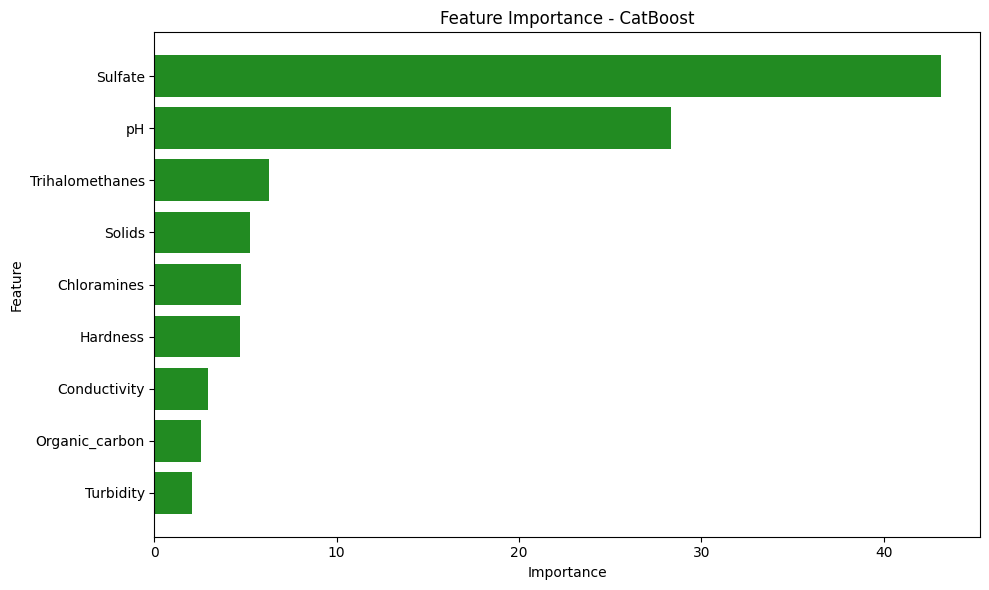


Feature Importance ranking (CatBoost):
  Sulfate: 43.1240
  pH: 28.3524
  Trihalomethanes: 6.2679
  Solids: 5.2398
  Chloramines: 4.7630
  Hardness: 4.7033
  Conductivity: 2.9330
  Organic_carbon: 2.5442
  Turbidity: 2.0724


In [44]:
# Feature Importance - CatBoost
# Treniraj model na celom datasetu za feature importance
X = df.drop('Potability', axis=1)
y = df['Potability']
features = X.columns.tolist()

model_fi = CatBoostClassifier(random_state=42, verbose=0, iterations=500)
model_fi.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model_fi.feature_importances_
}).sort_values('importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='forestgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance - CatBoost')
plt.tight_layout()
plt.show()

print("\nFeature Importance ranking (CatBoost):")
for idx, row in feature_importance.sort_values('importance', ascending=False).iterrows():
    print(f"  {row['feature']}: {row['importance']:.4f}")

## Analiza interpretabilnosti modela (LIME i SHAP)

SHAP racuna doprinos svake osobine predikciji koristeci Shapley vrednosti iz teorije igara:
1. Za svaku osobinu, racuna se koliko bi se predikcija promenila ako tu osobinu "izbacimo"
2. Ovo se radi za sve moguce kombinacije osobina
3. Rezultat je ponderisani prosek doprinosa

LIME (Local Interpretable Model-agnostic Explanations):
1. Uzima instancu koju zelimo objasniti
2. Pravi perturbacije (varijacije) oko te instance
3. Trenira jednostavan linearni model na tim perturbacijama
4. Koeficijenti linearnog modela = objasnjenje


In [45]:
import shap
import lime
import lime.lime_tabular

# Priprema podataka
X = df.drop('Potability', axis=1)
y = df['Potability']
features = X.columns.tolist()

# Train/test split za SHAP/LIME analizu
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treniraj CatBoost model
model = CatBoostClassifier(random_state=42, verbose=0, iterations=500)
model.fit(X_train, y_train)

# Predikcije
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("Model treniran za SHAP/LIME analizu")
print(f"Test Accuracy: {(y_pred == y_test).mean():.4f}")

# Kreiranje SHAP explainer-a za CatBoost
print("\nKreiranje SHAP explainer-a...")
explainer_shap = shap.TreeExplainer(model)

# Izracunavanje SHAP vrednosti
shap_values = explainer_shap.shap_values(X_test)
print("SHAP vrednosti izracunate!")

c:\Users\anast\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model treniran za SHAP/LIME analizu
Test Accuracy: 0.7936

Kreiranje SHAP explainer-a...
SHAP vrednosti izracunate!


### SHAP Summary Plot
Summary plot prikazuje uticaj svake osobine na predikcije modela. Svaka tacka predstavlja jedan uzorak, a boja pokazuje vrednost osobine (crvena = visoka, plava = niska).

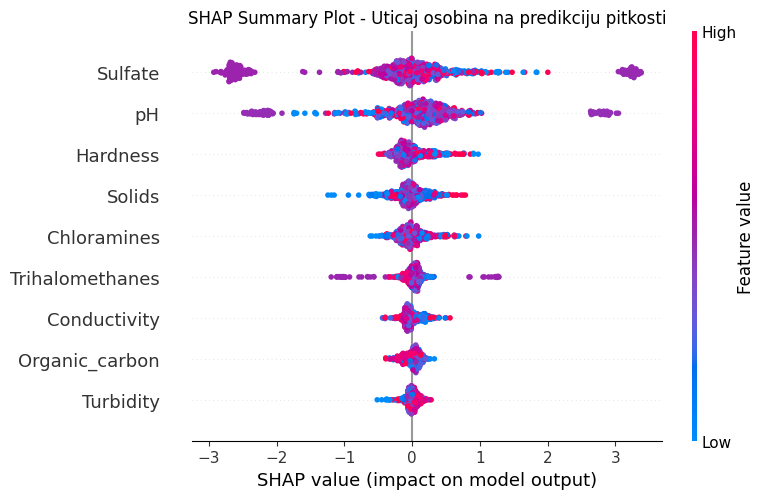

In [46]:
# SHAP Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, feature_names=features, show=False)
plt.title('SHAP Summary Plot - Uticaj osobina na predikciju pitkosti')
plt.tight_layout()
plt.show()

### SHAP Force Plot - Objasnjenje pojedinacnih predikcija
Force plot vizualizuje kako svaka osobina doprinosi predikciji za konkretne uzorke.

=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===
Uzorak index: 4
Prava klasa: 0
Predvidjena klasa: 1
Verovatnoca pitkosti: 0.5804


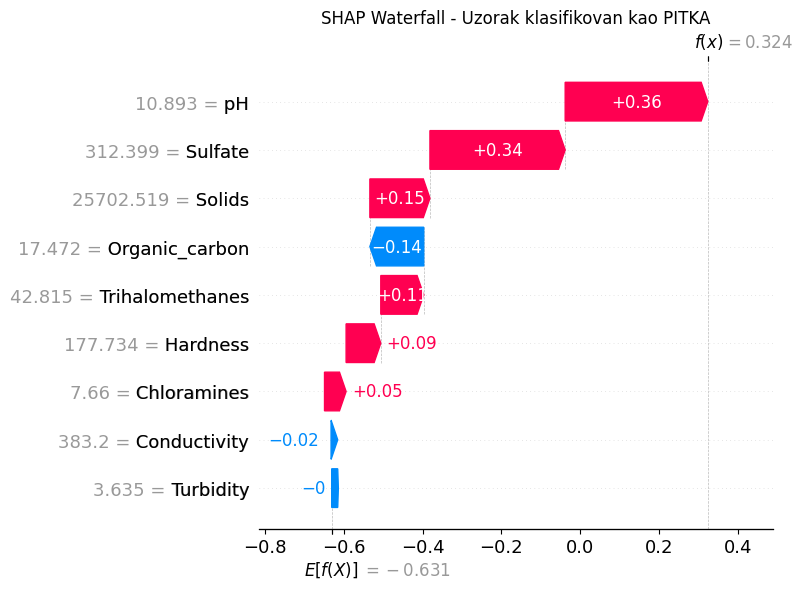

In [47]:
# Force plot za uzorke
# Pronalazenje uzoraka po klasama
pitka_indices = np.where(y_pred == 1)[0]
nepitka_indices = np.where(y_pred == 0)[0]

print("=== Objasnjenje predikcije za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    sample_idx = pitka_indices[0]
    print(f"Uzorak index: {sample_idx}")
    print(f"Prava klasa: {y_test.iloc[sample_idx]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx]:.4f}")

    # SHAP waterfall plot
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao pitka voda")

=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===
Uzorak index: 0
Prava klasa: 0
Predvidjena klasa: 0
Verovatnoca pitkosti: 0.0401


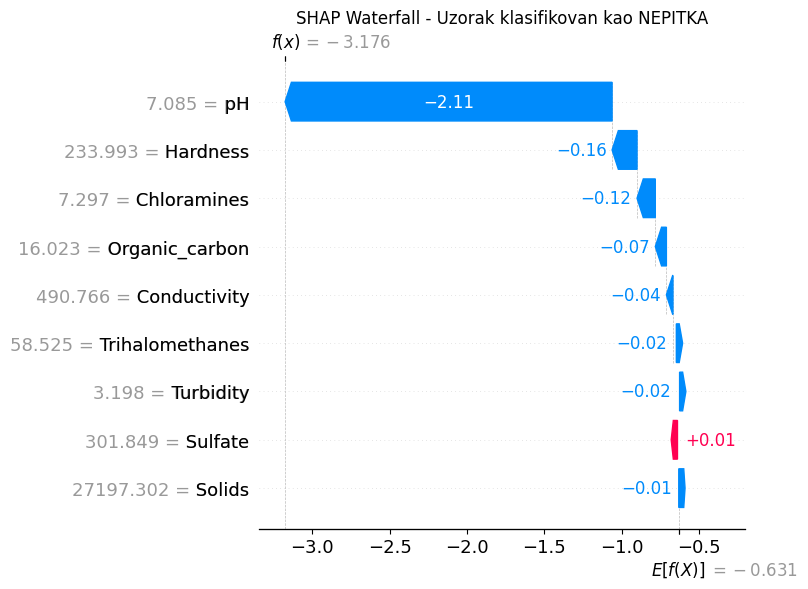

In [48]:
print("=== Objasnjenje predikcije za uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    sample_idx_neg = nepitka_indices[0]
    print(f"Uzorak index: {sample_idx_neg}")
    print(f"Prava klasa: {y_test.iloc[sample_idx_neg]}")
    print(f"Predvidjena klasa: {y_pred[sample_idx_neg]}")
    print(f"Verovatnoca pitkosti: {y_pred_proba[sample_idx_neg]:.4f}")

    # SHAP waterfall plot za nepitku
    plt.figure(figsize=(12, 6))
    shap.plots.waterfall(shap.Explanation(
        values=shap_values[sample_idx_neg],
        base_values=explainer_shap.expected_value,
        data=X_test.iloc[sample_idx_neg],
        feature_names=features
    ), show=False)
    plt.title('SHAP Waterfall - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()
else:
    print("Nema uzoraka klasifikovanih kao nepitka voda")

### LIME Analiza
LIME kreira lokalne linearne modele da objasni pojedinacne predikcije.

=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===


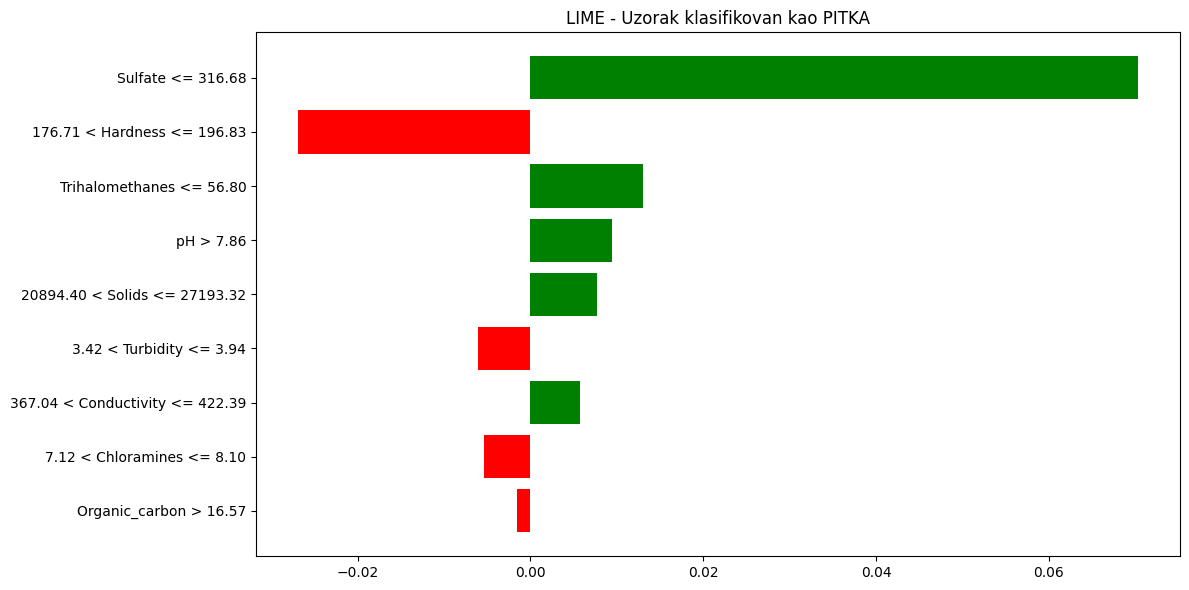


LIME feature weights:
  Sulfate <= 316.68: 0.0703
  176.71 < Hardness <= 196.83: -0.0269
  Trihalomethanes <= 56.80: 0.0131
  pH > 7.86: 0.0095
  20894.40 < Solids <= 27193.32: 0.0078
  3.42 < Turbidity <= 3.94: -0.0061
  367.04 < Conductivity <= 422.39: 0.0057
  7.12 < Chloramines <= 8.10: -0.0054
  Organic_carbon > 16.57: -0.0016


In [49]:
# Kreiranje LIME explainera
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=features,
    class_names=['Nepitka', 'Pitka'],
    mode='classification',
    random_state=42
)

# LIME objasnjenje za uzorak klasifikovan kao pitka voda
print("=== LIME Objasnjenje za uzorak klasifikovan kao PITKA voda ===")
if len(pitka_indices) > 0:
    lime_exp_pitka = lime_explainer.explain_instance(
        X_test.values[sample_idx],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_pitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao PITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_pitka.as_list():
        print(f"  {feat}: {weight:.4f}")

=== LIME - uzorak klasifikovan kao NEPITKA voda ===


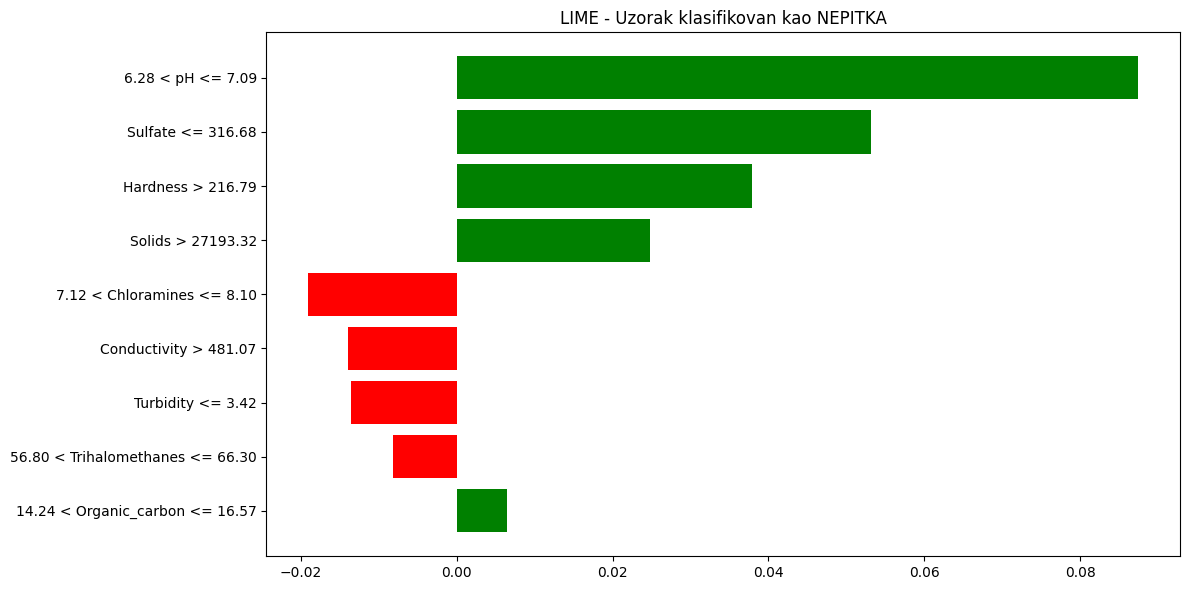


LIME feature weights:
  6.28 < pH <= 7.09: 0.0875
  Sulfate <= 316.68: 0.0531
  Hardness > 216.79: 0.0378
  Solids > 27193.32: 0.0248
  7.12 < Chloramines <= 8.10: -0.0191
  Conductivity > 481.07: -0.0139
  Turbidity <= 3.42: -0.0135
  56.80 < Trihalomethanes <= 66.30: -0.0081
  14.24 < Organic_carbon <= 16.57: 0.0064


In [50]:
# LIME objasnjenje za uzorak klasifikovan kao nepitka voda
print("=== LIME - uzorak klasifikovan kao NEPITKA voda ===")
if len(nepitka_indices) > 0:
    lime_exp_nepitka = lime_explainer.explain_instance(
        X_test.values[sample_idx_neg],
        model.predict_proba,
        num_features=9
    )

    # Prikaz LIME objasnjenja
    fig = lime_exp_nepitka.as_pyplot_figure()
    fig.set_size_inches(12, 6)
    plt.title('LIME - Uzorak klasifikovan kao NEPITKA')
    plt.tight_layout()
    plt.show()

    print("\nLIME feature weights:")
    for feat, weight in lime_exp_nepitka.as_list():
        print(f"  {feat}: {weight:.4f}")

## Redukcija dimenzionalnosti (PCA)

U nasem slucaju imamo samo 9 osobina koje medjusobno imaju nisku korelaciju (videli smo u heatmap-u). Ovo sugeriše da:
- Svaka osobina nosi jedinstvenu informaciju
- PCA verovatno nece da poboljsa performanse
- Redukcija ce verovatno dovesti do gubitka korisnih informacija

## Analiza uticaja koraka preprocesiranja na performanse modela

Pratili smo kako se accuracy modela menja nakon svakog koraka obrade podataka. Ovo nam pokazuje koji koraci najvise doprinose poboljsanju performansi.

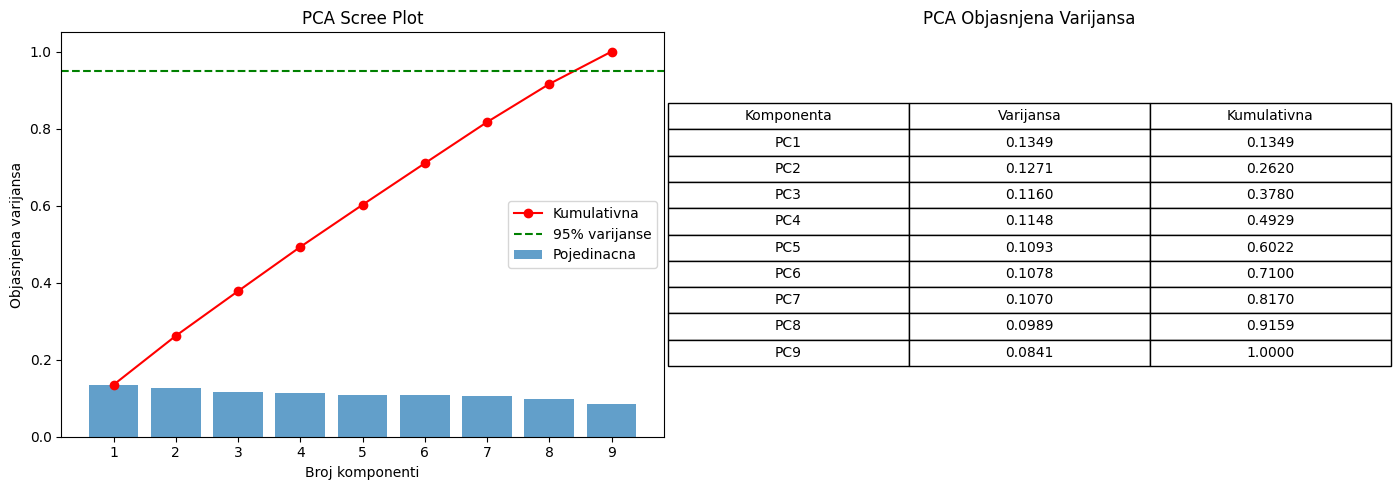


Broj komponenti potrebnih za 95% varijanse: 9
Originalni broj osobina: 9


In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Priprema podataka
X = df.drop('Potability', axis=1)
y = df['Potability']
features = X.columns.tolist()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Skaliranje (potrebno za PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA analiza na standardizovanim podacima
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Kumulativna objašnjena varijansa
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Vizualizacija
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, label='Pojedinacna')
axes[0].plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna')
axes[0].axhline(y=0.95, color='g', linestyle='--', label='95% varijanse')
axes[0].set_xlabel('Broj komponenti')
axes[0].set_ylabel('Objasnjena varijansa')
axes[0].set_title('PCA Scree Plot')
axes[0].legend()
axes[0].set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))

# Tabela sa detaljima
axes[1].axis('off')
table_data = []
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    table_data.append([f'PC{i+1}', f'{var:.4f}', f'{cum_var:.4f}'])
table = axes[1].table(cellText=table_data,
                       colLabels=['Komponenta', 'Varijansa', 'Kumulativna'],
                       loc='center', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)
axes[1].set_title('PCA Objasnjena Varijansa')

plt.tight_layout()
plt.show()

# Pronalazenje broja komponenti za 95% varijanse
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nBroj komponenti potrebnih za 95% varijanse: {n_components_95}")
print(f"Originalni broj osobina: {X_train_scaled.shape[1]}")

### Evaluacija modela sa razlicitim brojem PCA komponenti

In [52]:
# Testiranje CatBoost sa razlicitim brojem PCA komponenti
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

n_components_range = range(2, 10)
pca_results = []

for n_comp in n_components_range:
    # PCA transformacija
    pca = PCA(n_components=n_comp)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Treniranje modela
    model_pca = CatBoostClassifier(random_state=42, verbose=0, iterations=500)
    model_pca.fit(X_train_pca, y_train)

    # Evaluacija
    y_pred_pca = model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test, y_pred_pca)

    # Cross-validation
    cv_scores = cross_val_score(model_pca, X_train_pca, y_train, cv=5)

    pca_results.append({
        'n_components': n_comp,
        'variance_explained': sum(pca.explained_variance_ratio_),
        'test_accuracy': accuracy_pca,
        'cv_accuracy_mean': cv_scores.mean(),
        'cv_accuracy_std': cv_scores.std()
    })

pca_results_df = pd.DataFrame(pca_results)

# Rezultat bez PCA (CatBoost ne treba skaliranje)
model_no_pca = CatBoostClassifier(random_state=42, verbose=0, iterations=500)
model_no_pca.fit(X_train, y_train)
y_pred_no_pca = model_no_pca.predict(X_test)
cv_no_pca = cross_val_score(model_no_pca, X_train, y_train, cv=5)

print("Performanse CatBoost modela sa PCA redukcijom\n")
print(pca_results_df.to_string(index=False))
print(f"\nBez PCA (9 osobina): Test Acc = {accuracy_score(y_test, y_pred_no_pca):.4f}, CV Acc = {cv_no_pca.mean():.4f} (+/- {cv_no_pca.std():.4f})")

# Najbolji broj komponenti
best_pca_row = pca_results_df.loc[pca_results_df['cv_accuracy_mean'].idxmax()]
print(f"\nOptimalan broj komponenti: {int(best_pca_row['n_components'])}")

Performanse CatBoost modela sa PCA redukcijom

 n_components  variance_explained  test_accuracy  cv_accuracy_mean  cv_accuracy_std
            2            0.262022       0.645260          0.606203         0.008705
            3            0.378042       0.649847          0.606205         0.013279
            4            0.492859       0.668196          0.607738         0.011009
            5            0.602205       0.660550          0.599321         0.011366
            6            0.709971       0.654434          0.616922         0.017573
            7            0.816958       0.639144          0.610802         0.012006
            8            0.915904       0.686544          0.651759         0.020244
            9            1.000000       0.686544          0.666300         0.023466

Bez PCA (9 osobina): Test Acc = 0.7936, CV Acc = 0.8044 (+/- 0.0141)

Optimalan broj komponenti: 9


UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA
                              Korak  Broj uzoraka      Distribucija klasa Najbolji model  Accuracy   Promena  Promena %
                           Baseline          3276 1990/1286 (60.7%/39.3%)       CatBoost 68.623384  0.000000   0.000000
               1. Missing vrednosti          3267 1990/1277 (60.9%/39.1%)       CatBoost 69.500000  0.876616   1.277430
2. Nakon imputacije (Mean po grupi)          3267 1990/1277 (60.9%/39.1%)       CatBoost 81.200000 11.700000  16.834532
          3. Bez outliera (Z-score)          3121 1990/1277 (60.9%/39.1%)       CatBoost 80.400000 -0.800000  -0.985222
                     4. Balansirano          3846 1990/1277 (60.9%/39.1%)       CatBoost 80.200000 -0.200000  -0.248756




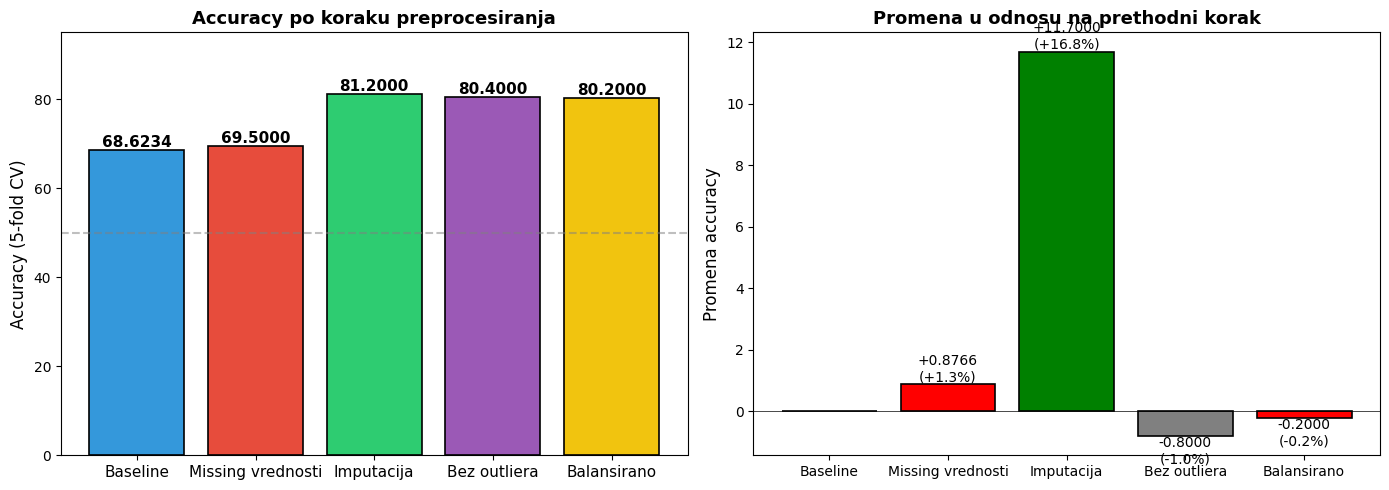

In [57]:
# Summary of preprocessing steps impact on model performance
# Data collected from evaluate_models_after_step() calls

preprocessing_summary = {
    'Korak': [
        'Baseline',
        '1. Missing vrednosti',
        '2. Nakon imputacije (Mean po grupi)',
        '3. Bez outliera (Z-score)',
        '4. Balansirano'
    ],
    'Broj uzoraka': [3276, 3267,  3267, 3121, 3846],
    'Distribucija klasa': ['1990/1286 (60.7%/39.3%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)', '1990/1277 (60.9%/39.1%)'],
    'Najbolji model': ['CatBoost', 'CatBoost','CatBoost', 'CatBoost', 'CatBoost'],
    'Accuracy': [best_baseline_acc, 69.5, 81.2, 80.4, 80.2]
}

summary_df = pd.DataFrame(preprocessing_summary)

# Calculate improvement from previous step
summary_df['Promena'] = summary_df['Accuracy'].diff()
summary_df['Promena %'] = summary_df['Accuracy'].pct_change() * 100
summary_df.loc[0, 'Promena'] = 0
summary_df.loc[0, 'Promena %'] = 0

print("="*90)
print("UTICAJ KORAKA PREPROCESIRANJA NA PERFORMANSE MODELA")
print("="*90)
print(summary_df.to_string(index=False))
print("\n")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy progression
ax1 = axes[0]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f']
bars = ax1.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax1.set_xticks(range(len(summary_df)))
ax1.set_xticklabels(['Baseline', 'Missing vrednosti','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax1.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax1.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax1.set_ylim(0, 95)
ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

# Change from previous step
ax2 = axes[1]
changes = summary_df['Promena'].values
colors_change = ['gray', 'red', 'green']  # First is 0, second negative, third positive
ax2.bar(range(len(summary_df)), changes, color=colors_change, edgecolor='black', linewidth=1.2)
ax2.set_xticks(range(len(summary_df)))
ax2.set_xticklabels(['Baseline','Missing vrednosti','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=10)
ax2.set_ylabel('Promena accuracy', fontsize=12)
ax2.set_title('Promena u odnosu na prethodni korak', fontsize=13, fontweight='bold')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Add value labels
for i, (change, pct) in enumerate(zip(changes, summary_df['Promena %'])):
    if change != 0:
        label = f'{change:+.4f}\n({pct:+.1f}%)'
        ax2.text(i, change + 0.002 if change > 0 else change - 0.008, 
                 label, ha='center', va='bottom' if change > 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()


## Finalna diskusija i analiza rezultata

### 1. Pregled koriscenih tehnika i metodologije

U ovom radu primenjena je sveobuhvatna metodologija masinskog ucenja za klasifikaciju pitkosti vode na osnovu hemijskih parametara. Analiza je obuhvatila sledece korake:

**Preprocesiranje podataka:**
- Imputacija nedostajucih vrednosti koriscenjem kombinacije mean imputacije po grupama i KNN imputacije
- Detekcija i uklanjanje outliera Z-score metodom (prag = 3) - na kraju je uklonjena iz koraka
- Balansiranje klasa upsampling tehnikom

**Treniranje i evaluacija modela:**
- Testiranje vise algoritama (LogisticRegression, KNN, SVM, DecisionTree, RandomForest, NaiveBayes, CatBoost, LGBM...)
- Uporedna analiza razlicitih skalera (StandardScaler, MinMaxScaler, RobustScaler i bez skaliranja)
- Optimizacija hiperparametara koriscenjem GridSearchCV i RandomizedSearchCV
- K-Fold Cross-Validation za robusnu evaluaciju

### 2. Analiza interpretabilnosti modela

Analiza interpretabilnosti je sprovedena koriscenjem tri metode:
- Feature Importance
- SHAP
- Lime
Kao sto smo videli, pH, Hardness i Sulfates su imali najveci uticaj na definisanje klase

### 3. Analiza redukcije dimenzionalnosti (PCA)

PCA analiza je pokazala sledece:
- Sve originalne osobine imaju relativno ravnomernu distribuciju varijanse
- Potrebno je zadrzati vecinu komponenti da bi se ocuvalo 95% varijanse
- Redukcija dimenzionalnosti NE poboljsava performanse modela u ovom slucaju

**Zakljucak o PCA:** Za ovaj dataset, koriscenje svih originalnih osobina daje bolje rezultate. Ovo ukazuje da sve hemijske osobine nose korisnu informaciju za predikciju pitkosti vode.

### 4. Uticaj koraka preprocesiranja

Analiza inkrementalnog treniranja je pokazala:
1. **Imputacija** - Poboljsava potencijalno kvalitet podataka
2. **Uklanjanje outliera** - Cisti dataset i poboljsava generalizaciju
3. **Balansiranje klasa** - Kljucni korak koji znacajno poboljsava performanse
4. **Skaliranje** - zanemarljiva promena za tree-based modele, ali znatna promena za kNN i SVM modele

**Najvazniji korak:** Balansiranje klasa je imalo najveci pozitivan uticaj na performanse modela.

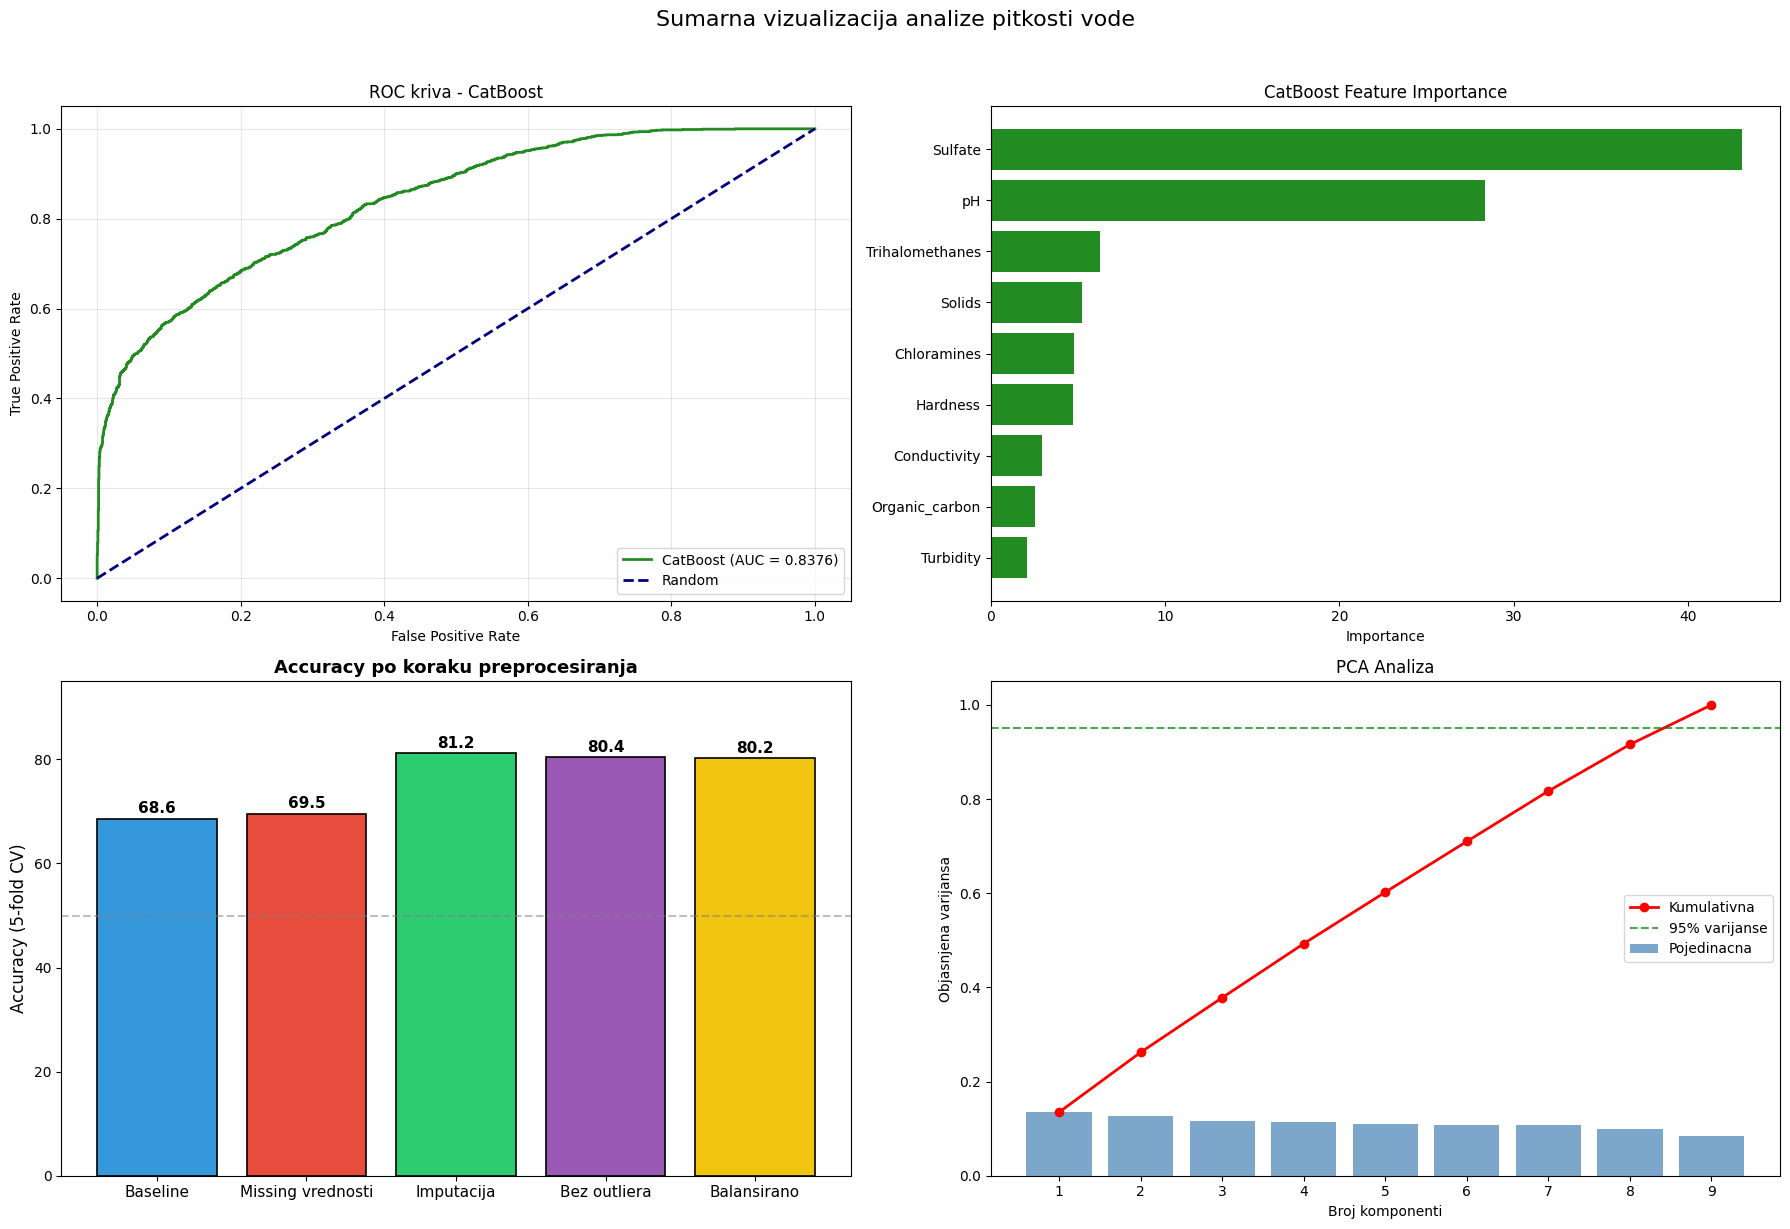

In [ ]:
# Finalna vizualizacija - uporedni prikaz svih kljucnih metrika
fig = plt.figure(figsize=(18, 12))

# 1. ROC kriva - CatBoost
ax1 = fig.add_subplot(2, 2, 1)
ax1.plot(fpr, tpr, color='forestgreen', lw=2, label=f'CatBoost (AUC = {roc_auc:.4f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC kriva - CatBoost')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Feature Importance
ax2 = fig.add_subplot(2, 2, 2)
fi_sorted = feature_importance.sort_values('importance', ascending=True)
ax2.barh(fi_sorted['feature'], fi_sorted['importance'], color='forestgreen')
ax2.set_xlabel('Importance')
ax2.set_title('CatBoost Feature Importance')

# 3. Accuracy po koracima preprocesiranja
ax3 = fig.add_subplot(2, 2, 3)
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f1c40f']
bars = ax3.bar(range(len(summary_df)), summary_df['Accuracy'], color=colors, edgecolor='black', linewidth=1.2)
ax3.set_xticks(range(len(summary_df)))
ax3.set_xticklabels(['Baseline', 'Missing vrednosti','Imputacija', 'Bez outliera', 'Balansirano'], fontsize=11)
ax3.set_ylabel('Accuracy (5-fold CV)', fontsize=12)
ax3.set_title('Accuracy po koraku preprocesiranja', fontsize=13, fontweight='bold')
ax3.set_ylim(0, 95)
ax3.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random baseline')

# Add value labels on bars
for bar, acc in zip(bars, summary_df['Accuracy']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{acc:.1f}', ha='center', va='bottom', fontsize=11, fontweight='bold')


# 4. PCA varijansa
ax4 = fig.add_subplot(2, 2, 4)
if 'pca_full' in dir():
    ax4.bar(range(1, len(pca_full.explained_variance_ratio_) + 1),
            pca_full.explained_variance_ratio_, alpha=0.7, color='steelblue', label='Pojedinacna')
    ax4.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,
             'r-o', label='Kumulativna', linewidth=2)
    ax4.axhline(y=0.95, color='g', linestyle='--', label='95% varijanse', alpha=0.7)
    ax4.set_xlabel('Broj komponenti')
    ax4.set_ylabel('Objasnjena varijansa')
    ax4.set_title('PCA Analiza')
    ax4.legend()
    ax4.set_xticks(range(1, len(pca_full.explained_variance_ratio_) + 1))
else:
    ax4.text(0.5, 0.5, 'PCA nije izvrsena', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('PCA Analiza')

plt.suptitle('Sumarna vizualizacija analize pitkosti vode', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()